In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import pandas as pd
import pickle


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2023-01-11 16:05:56.188016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load data

0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [2]:
def load_data(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    data0 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    data1 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data1.p", "rb" ))
    data2 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data2.p", "rb" ))
    data3 = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data3.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, data0, data1, data2, data3, y

Function to standardize input features

In [3]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

Plot reults

In [4]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()
    
def get_results(h):
    test = [s[1] for s in h]
    plot = [s[0] for s in h]

    print(f'Test set results:{test}\nAverage loss:{np.average([s[0] for s in test])}\nAverage accuracy:{np.average([s[1] for s in test])}') 

    plot_stats(plot)

# Model definition

In [5]:
def train_evaluate(model_fn, train, val, test, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    # test
    print("Evaluate on test data")
    results = m.evaluate(test[0], test[1], batch_size=32)
    print("test loss, test acc:", results)
    return history, results

In [6]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.2, 
                                   random_state = 2022,
                                   stratify = metadata['label'])
    test_index = test_df.index
    x_test = x[test_index]
    y_test = y[test_index]
    for rs in n:
        trainK_df, val_df = train_test_split(train_df, 
                                   test_size = 0.2, 
                                   random_state = rs,
                                   stratify = train_df['label'])
        train_index = trainK_df.index
        val_index = val_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_val = x[val_index]
        y_val = y[val_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_val, y_val), (x_test, y_test)))
    return results

In [7]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2023-01-03 09:45:13.897145: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-03 09:45:13.897966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-03 09:45:13.961134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-01-03 09:45:13.961161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-03 09:45:13.962894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-03 09:45:13.962956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

In [8]:
def experiments(metadata, data, y, get_m):
    res = []
    for d in data:
        r = train_kfold(get_m, d, y, metadata)
        get_results(r)
        res.append(r)
    return res

# EMODB

In [4]:
metadata, data0, data1, data2, data3, y = load_data('emodb')
metadata

path     filename  chunk  \
0     /datasets/nicolas_facchinetti/emodb/data/13a05...  13a05Tc.wav      0   
1     /datasets/nicolas_facchinetti/emodb/data/13a05...  13a05Tc.wav      1   
2     /datasets/nicolas_facchinetti/emodb/data/13a05...  13a05Tc.wav      0   
3     /datasets/nicolas_facchinetti/emodb/data/13a05...  13a05Tc.wav      1   
4     /datasets/nicolas_facchinetti/emodb/data/13a05...  13a05Tc.wav      0   
...                                                 ...          ...    ...   
4176  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
4177  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      1   
4178  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
4179  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
4180  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   

      label  actor gender  mod  
0       sad     13      f    0  
1       sad     13      f    0  
2       sad     13      f    1  
3       sad     13      f    1  
4       sad     13      f    1  
...     ...    ...    ...  ...  
4176  happy      8      f    2  
4177  happy      8      f    2  
4178  happy      8      f    2  
4179  happy      8      f    2  
4180  happy      8      f    2  

[4181 rows x 7 columns]

In [10]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape,

((4181, 261, 128, 1),
 (4181, 261, 128, 1),
 (4181, 261, 128, 1),
 (4181, 261, 128, 1),
 (4181, 5))

## Without standardization

2023-01-03 09:45:18.153940: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 357465600 exceeds 10% of free system memory.
2023-01-03 09:45:18.366638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-03 09:45:18.383503: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/50


2023-01-03 09:45:19.428079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-03 09:45:19.653249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


84/84 [==============================] - 4s 23ms/step - loss: 1.6086 - accuracy: 0.2134 - val_loss: 1.6273 - val_accuracy: 0.2481
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5115 - accuracy: 0.3204 - val_loss: 1.6831 - val_accuracy: 0.2616
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4579 - accuracy: 0.3376 - val_loss: 1.4176 - val_accuracy: 0.3318
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3833 - accuracy: 0.3588 - val_loss: 1.4166 - val_accuracy: 0.3543
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3404 - accuracy: 0.3742 - val_loss: 1.4073 - val_accuracy: 0.3124
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2949 - accuracy: 0.4164 - val_loss: 1.3676 - val_accuracy: 0.4544
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2285 - accuracy: 0.4528 - val_loss: 1.3548 - val_accuracy: 0.4335
Epoch 8/50
84/84 [======

2023-01-03 09:46:13.125251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 111849984 exceeds 10% of free system memory.


test loss, test acc: [0.7707324624061584, 0.7335723042488098]


2023-01-03 09:46:13.732121: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 357465600 exceeds 10% of free system memory.


Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5816 - accuracy: 0.2399 - val_loss: 1.5171 - val_accuracy: 0.2900
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4855 - accuracy: 0.3233 - val_loss: 1.4750 - val_accuracy: 0.2706
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4101 - accuracy: 0.4000 - val_loss: 1.4598 - val_accuracy: 0.3976
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4080 - accuracy: 0.3851 - val_loss: 1.3908 - val_accuracy: 0.3677
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3649 - accuracy: 0.4252 - val_loss: 1.3880 - val_accuracy: 0.4425
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3044 - accuracy: 0.4920 - val_loss: 1.2743 - val_accuracy: 0.4798
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2295 - accuracy: 0.5470 - val_loss: 1.2575 - val_accuracy: 0.4948
Epoch 8/50
84

2023-01-03 09:47:19.532122: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 111849984 exceeds 10% of free system memory.


test loss, test acc: [0.9428597688674927, 0.6248506307601929]


2023-01-03 09:47:20.132058: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 357465600 exceeds 10% of free system memory.


Epoch 1/50
84/84 [==============================] - 3s 19ms/step - loss: 1.6128 - accuracy: 0.2552 - val_loss: 1.5765 - val_accuracy: 0.2496
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5249 - accuracy: 0.2798 - val_loss: 1.4927 - val_accuracy: 0.2735
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4220 - accuracy: 0.3360 - val_loss: 1.4594 - val_accuracy: 0.3109
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3150 - accuracy: 0.3826 - val_loss: 1.3631 - val_accuracy: 0.3692
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2567 - accuracy: 0.4277 - val_loss: 1.4341 - val_accuracy: 0.4619
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2364 - accuracy: 0.4735 - val_loss: 1.2624 - val_accuracy: 0.4484
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1823 - accuracy: 0.4812 - val_loss: 1.3199 - val_accuracy: 0.3767
Epoch 8/50
84

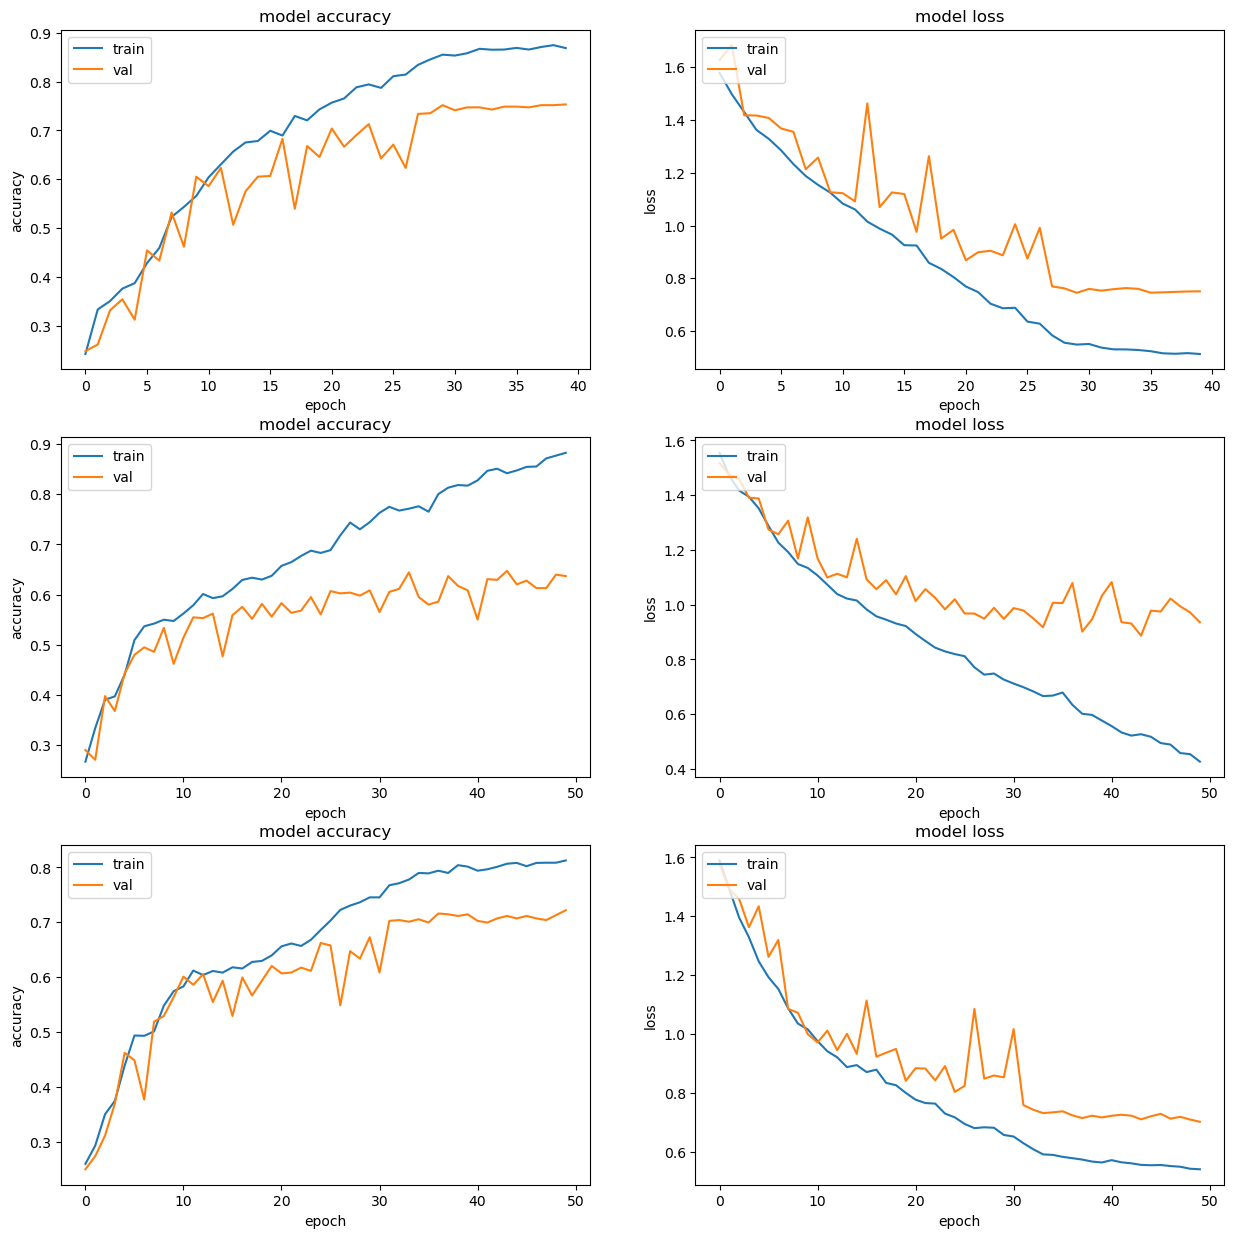

Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5994 - accuracy: 0.2463 - val_loss: 1.5961 - val_accuracy: 0.2451
Epoch 2/50
84/84 [==============================] - 1s 16ms/step - loss: 1.5958 - accuracy: 0.2525 - val_loss: 1.5963 - val_accuracy: 0.2317
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5973 - accuracy: 0.2406 - val_loss: 1.5943 - val_accuracy: 0.2451
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5931 - accuracy: 0.2257 - val_loss: 1.5941 - val_accuracy: 0.2451
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5933 - accuracy: 0.2507 - val_loss: 1.5941 - val_accuracy: 0.2451
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5948 - accuracy: 0.2443 - val_loss: 1.5940 - val_accuracy: 0.2451
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.6017 - accuracy: 0.2391 - val_loss: 1.5939 - val_accuracy: 0.2451
Epoch 8/50
84

Epoch 11/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4343 - accuracy: 0.3884 - val_loss: 1.6382 - val_accuracy: 0.2526
Epoch 12/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4222 - accuracy: 0.3931 - val_loss: 1.6515 - val_accuracy: 0.2466
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Done
Evaluate on test data
27/27 [==============================] - 0s 5ms/step - loss: 1.5941 - accuracy: 0.2449
test loss, test acc: [1.5941317081451416, 0.24492233991622925]
Test set results:[[0.9209124445915222, 0.5925925970077515], [1.0066415071487427, 0.5543608069419861], [1.5941317081451416, 0.24492233991622925]]
Average loss:1.1738952199618022
Average accuracy:0.4639585812886556


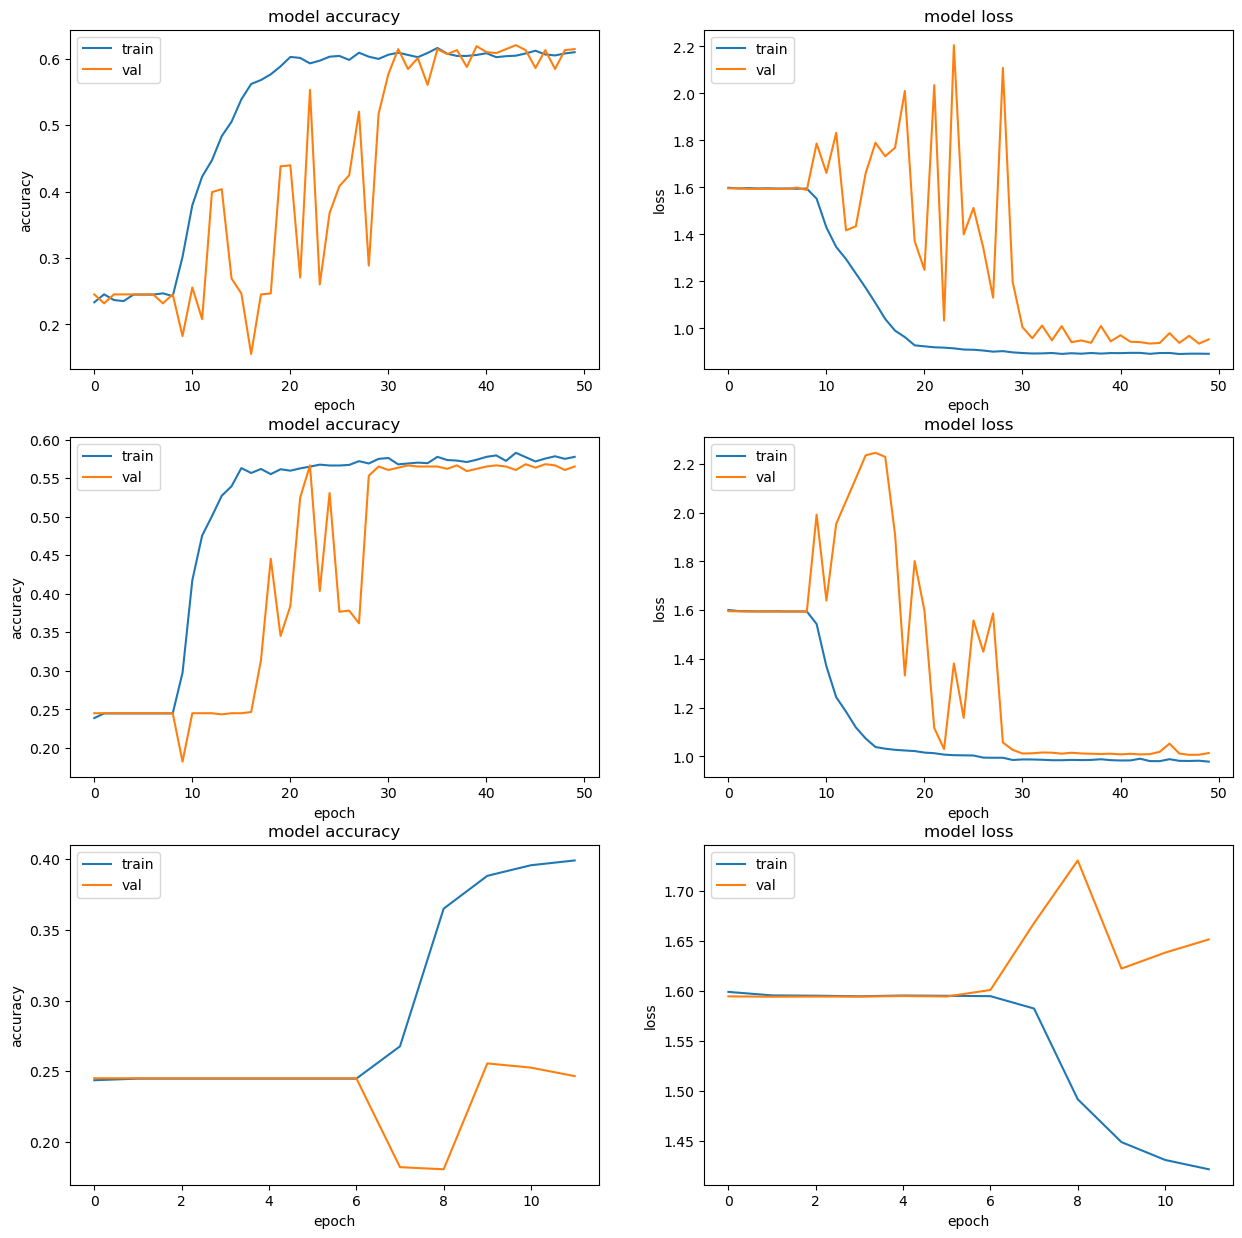

Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5897 - accuracy: 0.2731 - val_loss: 1.6416 - val_accuracy: 0.1988
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4537 - accuracy: 0.3860 - val_loss: 1.3523 - val_accuracy: 0.4664
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2864 - accuracy: 0.4718 - val_loss: 1.4326 - val_accuracy: 0.4051
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2051 - accuracy: 0.5066 - val_loss: 2.4340 - val_accuracy: 0.2451
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1251 - accuracy: 0.5301 - val_loss: 1.3616 - val_accuracy: 0.4155
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0180 - accuracy: 0.6085 - val_loss: 1.0642 - val_accuracy: 0.5740
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9919 - accuracy: 0.6155 - val_loss: 0.9958 - val_accuracy: 0.5919
Epoch 8/50
84

Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9347 - accuracy: 0.6526 - val_loss: 1.0756 - val_accuracy: 0.5680
Epoch 8/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9279 - accuracy: 0.6625 - val_loss: 0.9376 - val_accuracy: 0.6383
Epoch 9/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8631 - accuracy: 0.6789 - val_loss: 1.0589 - val_accuracy: 0.5635
Epoch 10/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8246 - accuracy: 0.6803 - val_loss: 0.8883 - val_accuracy: 0.6682
Epoch 11/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8212 - accuracy: 0.6894 - val_loss: 0.8896 - val_accuracy: 0.6876
Epoch 12/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8034 - accuracy: 0.6859 - val_loss: 0.9263 - val_accuracy: 0.6099
Epoch 13/50
84/84 [==============================] - 1s 15ms/step - loss: 0.7460 - accuracy: 0.7194 - val_loss: 0.8829 - val_accuracy: 0.6487
Epoch 14/

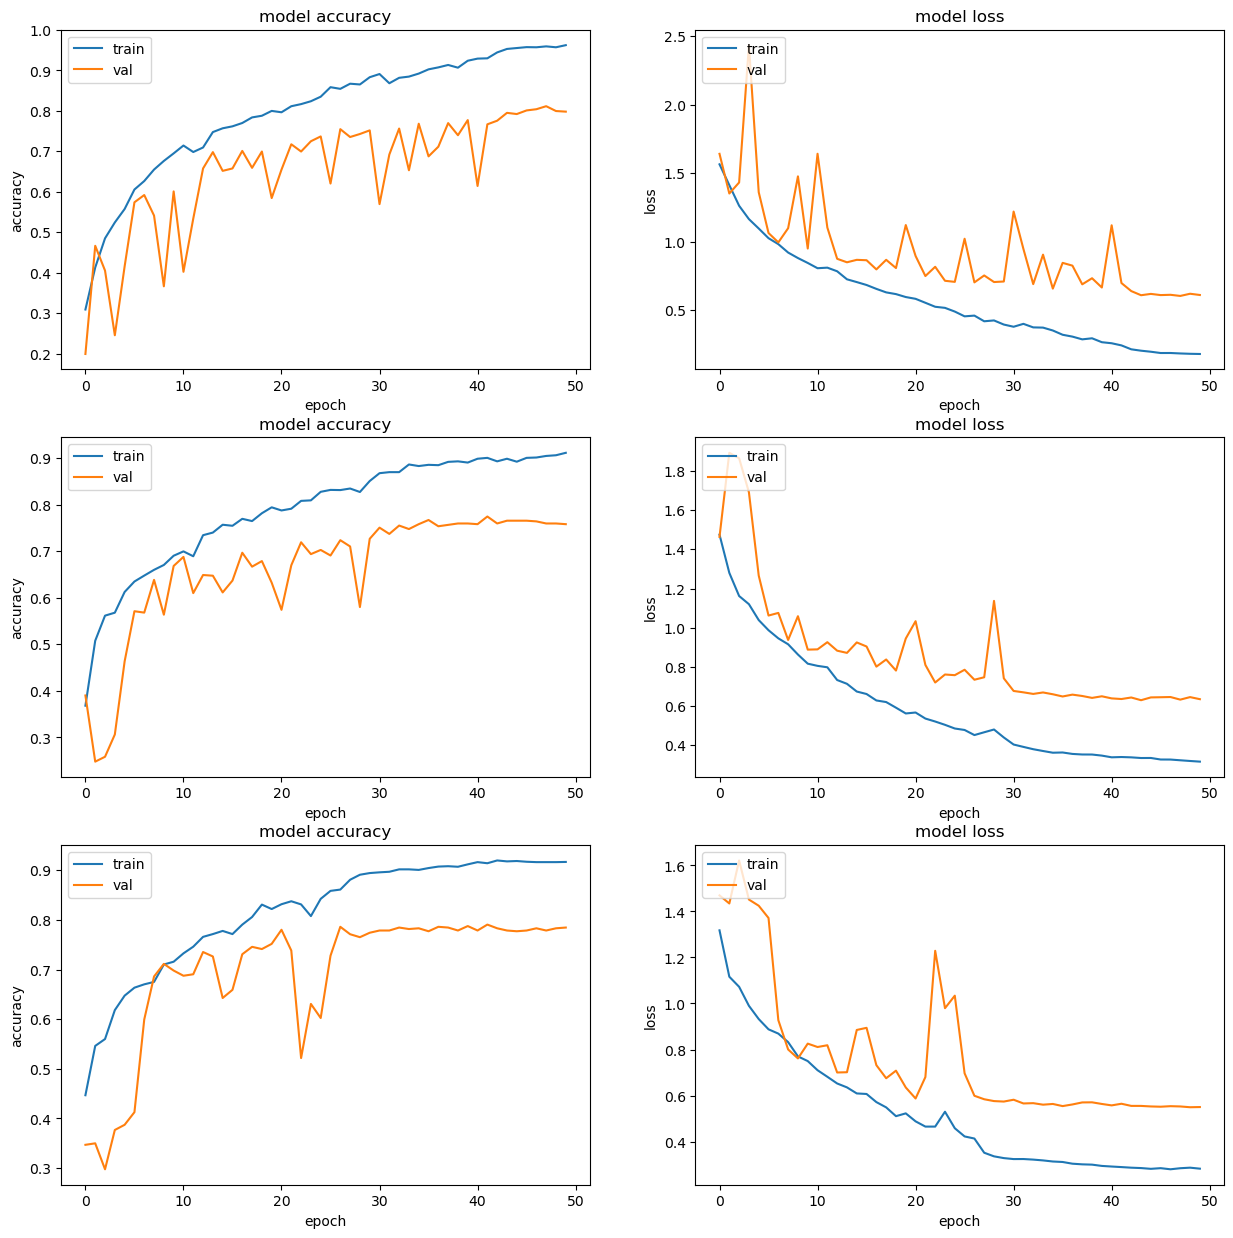

Epoch 1/50
84/84 [==============================] - 3s 19ms/step - loss: 1.5833 - accuracy: 0.2519 - val_loss: 1.5987 - val_accuracy: 0.2422
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5137 - accuracy: 0.3047 - val_loss: 1.6297 - val_accuracy: 0.2451
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5003 - accuracy: 0.3244 - val_loss: 1.6286 - val_accuracy: 0.2451
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4772 - accuracy: 0.3272 - val_loss: 1.5297 - val_accuracy: 0.2496
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4534 - accuracy: 0.3408 - val_loss: 1.4805 - val_accuracy: 0.2706
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4395 - accuracy: 0.3409 - val_loss: 1.4591 - val_accuracy: 0.2825
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4283 - accuracy: 0.3436 - val_loss: 1.4365 - val_accuracy: 0.2900
Epoch 8/50
84

84/84 [==============================] - 1s 15ms/step - loss: 1.0265 - accuracy: 0.5994 - val_loss: 1.1161 - val_accuracy: 0.5396
Epoch 22/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0137 - accuracy: 0.5827 - val_loss: 1.1107 - val_accuracy: 0.5366
Epoch 23/50
84/84 [==============================] - 1s 16ms/step - loss: 0.9982 - accuracy: 0.5925 - val_loss: 1.0823 - val_accuracy: 0.5546
Epoch 24/50
84/84 [==============================] - 1s 16ms/step - loss: 0.9952 - accuracy: 0.5928 - val_loss: 1.0906 - val_accuracy: 0.5546
Epoch 25/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9508 - accuracy: 0.5959 - val_loss: 1.0759 - val_accuracy: 0.5441
Epoch 26/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9604 - accuracy: 0.5966 - val_loss: 1.0695 - val_accuracy: 0.5486
Epoch 27/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9295 - accuracy: 0.6076 - val_loss: 1.0650 - val_accuracy: 0.5546
Epoch 28/50
84/84 

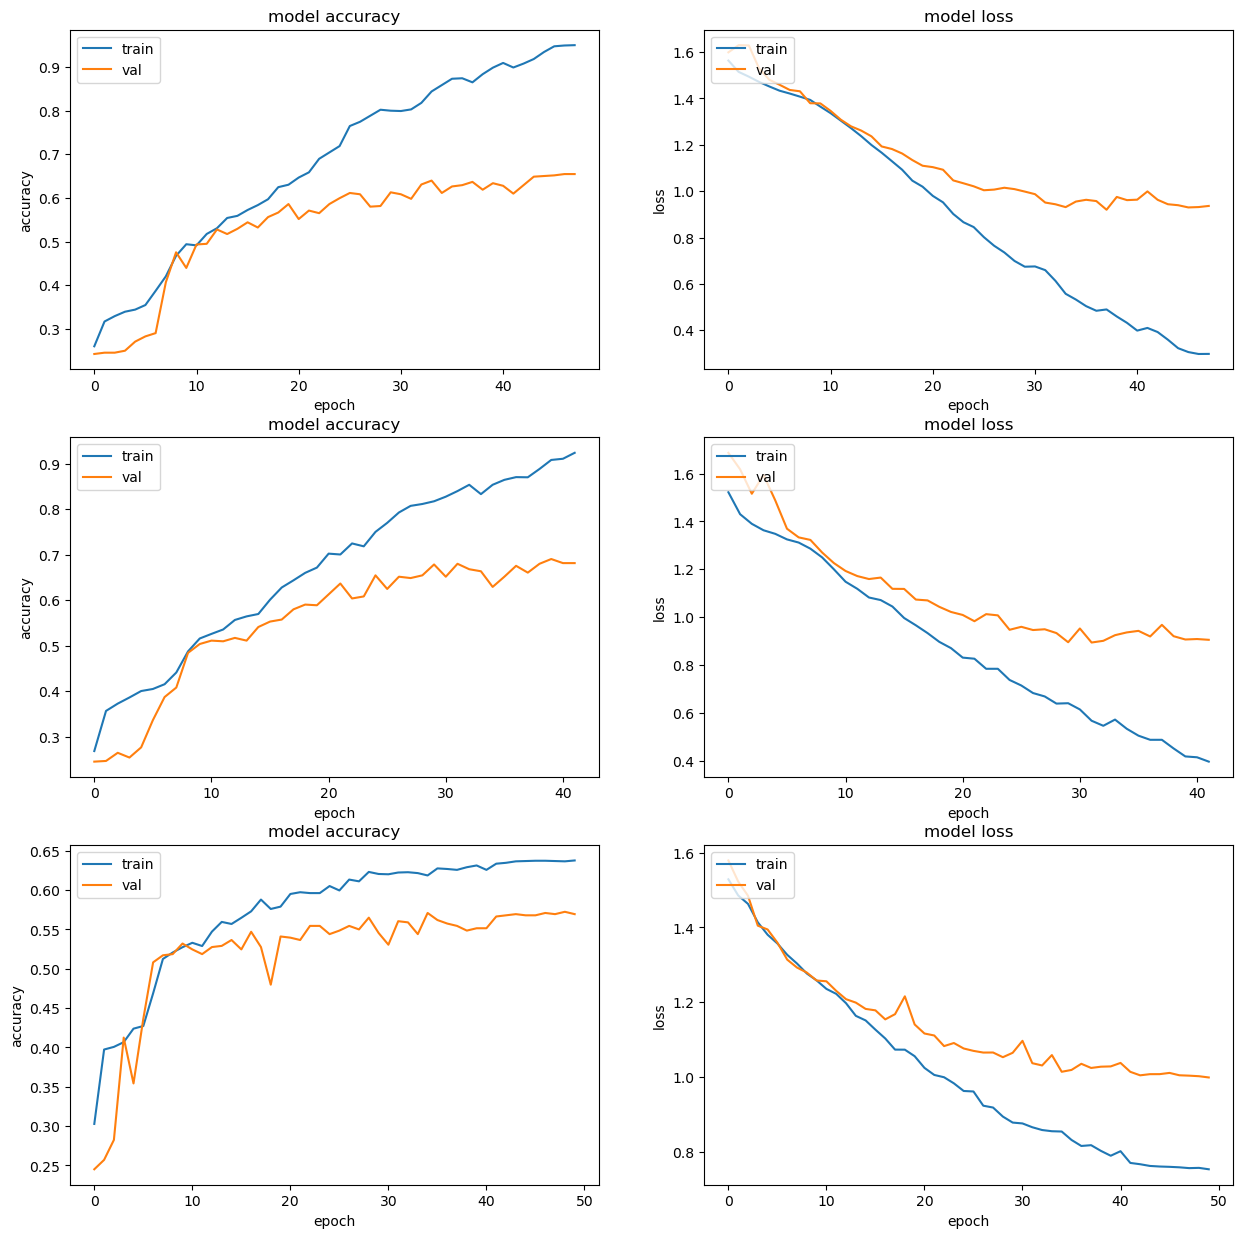

In [11]:
emodb1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [12]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
84/84 [==============================] - 3s 19ms/step - loss: 1.5969 - accuracy: 0.2336 - val_loss: 1.5540 - val_accuracy: 0.2720
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.5223 - accuracy: 0.3209 - val_loss: 1.4745 - val_accuracy: 0.3677
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4557 - accuracy: 0.3824 - val_loss: 1.4246 - val_accuracy: 0.3752
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4285 - accuracy: 0.3581 - val_loss: 1.3671 - val_accuracy: 0.4230
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3433 - accuracy: 0.4238 - val_loss: 1.3127 - val_accuracy: 0.4380
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2531 - accuracy: 0.4620 - val_loss: 1.2493 - val_accuracy: 0.4380
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2112 - accuracy: 0.4927 - val_loss: 1.1842 - val_accuracy: 0.5262
Epoch 8/50
84

Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2041 - accuracy: 0.5633 - val_loss: 1.2198 - val_accuracy: 0.5830
Epoch 8/50
84/84 [==============================] - 1s 16ms/step - loss: 1.1707 - accuracy: 0.5790 - val_loss: 1.1750 - val_accuracy: 0.5815
Epoch 9/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1408 - accuracy: 0.6069 - val_loss: 1.1460 - val_accuracy: 0.5785
Epoch 10/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1121 - accuracy: 0.6078 - val_loss: 1.1264 - val_accuracy: 0.6054
Epoch 11/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0626 - accuracy: 0.6488 - val_loss: 1.0972 - val_accuracy: 0.6173
Epoch 12/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0359 - accuracy: 0.6784 - val_loss: 1.0779 - val_accuracy: 0.6173
Epoch 13/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0037 - accuracy: 0.6749 - val_loss: 1.0799 - val_accuracy: 0.6218
Epoch 14/

Epoch 13/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9658 - accuracy: 0.6317 - val_loss: 0.9739 - val_accuracy: 0.6158
Epoch 14/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9691 - accuracy: 0.6267 - val_loss: 0.9795 - val_accuracy: 0.5979
Epoch 15/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9451 - accuracy: 0.6181 - val_loss: 0.9517 - val_accuracy: 0.6143
Epoch 16/50
84/84 [==============================] - 1s 15ms/step - loss: 0.9065 - accuracy: 0.6557 - val_loss: 0.9331 - val_accuracy: 0.6233
Epoch 17/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8850 - accuracy: 0.6614 - val_loss: 0.9291 - val_accuracy: 0.6263
Epoch 18/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8586 - accuracy: 0.6801 - val_loss: 0.9177 - val_accuracy: 0.6129
Epoch 19/50
84/84 [==============================] - 1s 15ms/step - loss: 0.8533 - accuracy: 0.6671 - val_loss: 0.9014 - val_accuracy: 0.6263
Epoch 

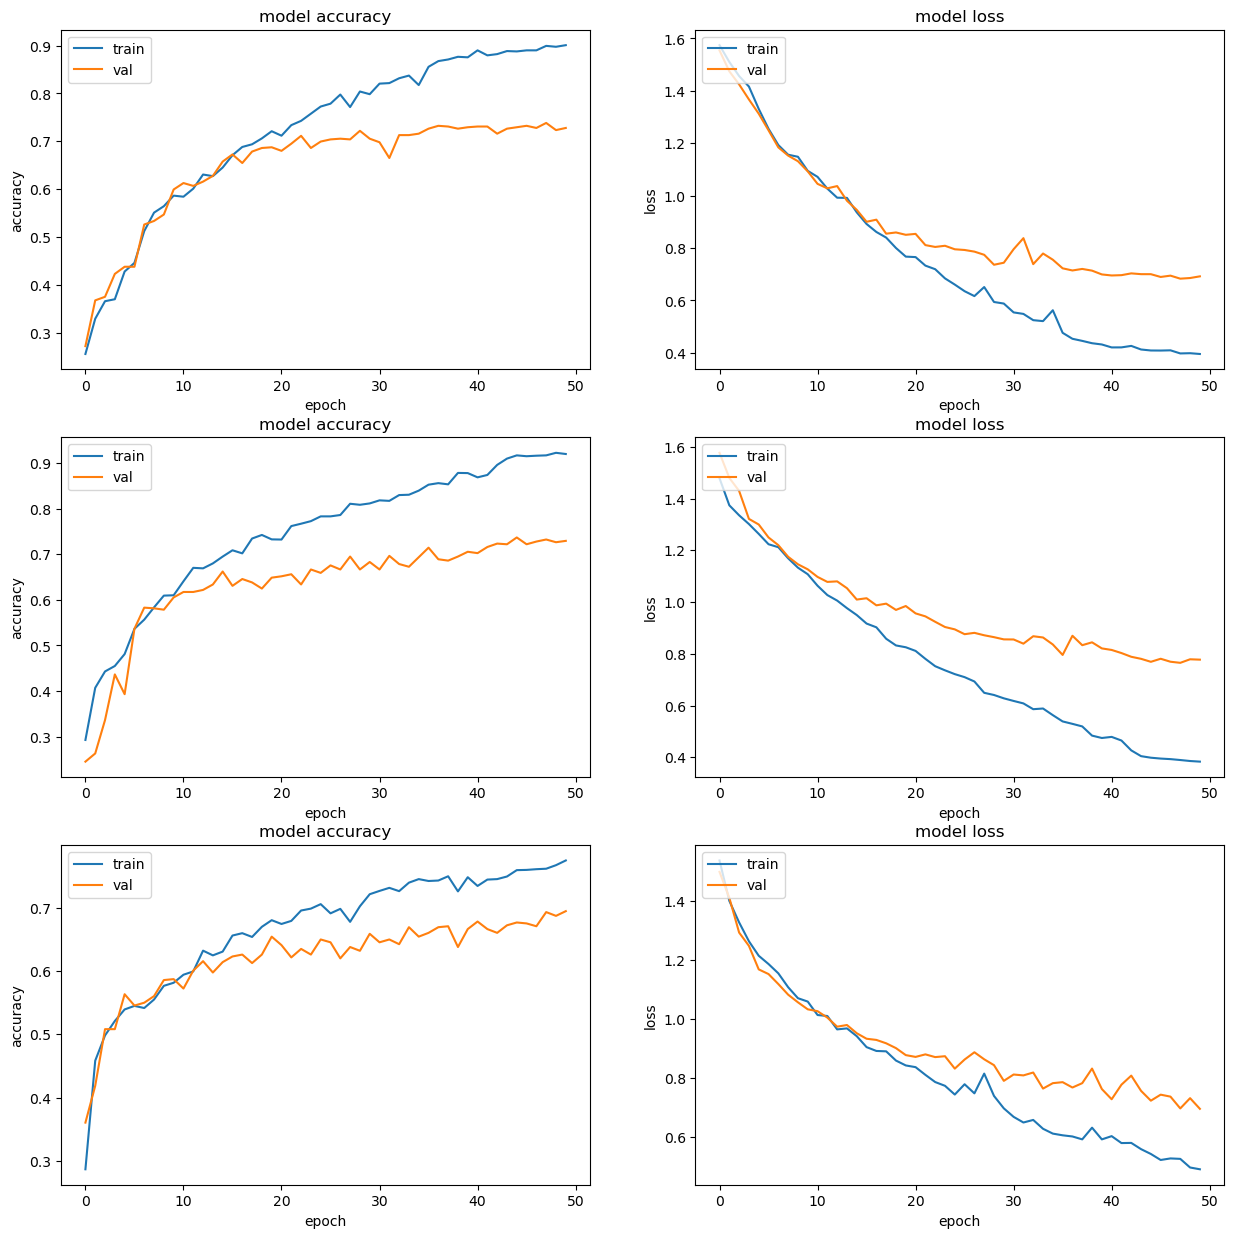

Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5622 - accuracy: 0.2522 - val_loss: 1.4995 - val_accuracy: 0.2466
Epoch 2/50
84/84 [==============================] - 1s 16ms/step - loss: 1.4540 - accuracy: 0.3113 - val_loss: 1.4461 - val_accuracy: 0.3184
Epoch 3/50
84/84 [==============================] - 1s 16ms/step - loss: 1.3638 - accuracy: 0.3862 - val_loss: 1.3191 - val_accuracy: 0.4798
Epoch 4/50
84/84 [==============================] - 1s 16ms/step - loss: 1.3324 - accuracy: 0.4498 - val_loss: 1.2600 - val_accuracy: 0.4873
Epoch 5/50
84/84 [==============================] - 1s 16ms/step - loss: 1.2007 - accuracy: 0.5207 - val_loss: 1.1386 - val_accuracy: 0.5561
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1727 - accuracy: 0.5390 - val_loss: 1.1340 - val_accuracy: 0.5396
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0823 - accuracy: 0.5632 - val_loss: 1.1153 - val_accuracy: 0.5247
Epoch 8/50
84

Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3035 - accuracy: 0.5268 - val_loss: 1.2956 - val_accuracy: 0.5336
Epoch 8/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2573 - accuracy: 0.5397 - val_loss: 1.2444 - val_accuracy: 0.5546
Epoch 9/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2362 - accuracy: 0.5415 - val_loss: 1.2213 - val_accuracy: 0.5590
Epoch 10/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1947 - accuracy: 0.5634 - val_loss: 1.1988 - val_accuracy: 0.5680
Epoch 11/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1848 - accuracy: 0.5847 - val_loss: 1.1818 - val_accuracy: 0.5889
Epoch 12/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1440 - accuracy: 0.6058 - val_loss: 1.1542 - val_accuracy: 0.6024
Epoch 13/50
84/84 [==============================] - 1s 16ms/step - loss: 1.1157 - accuracy: 0.6172 - val_loss: 1.1415 - val_accuracy: 0.5979
Epoch 14/

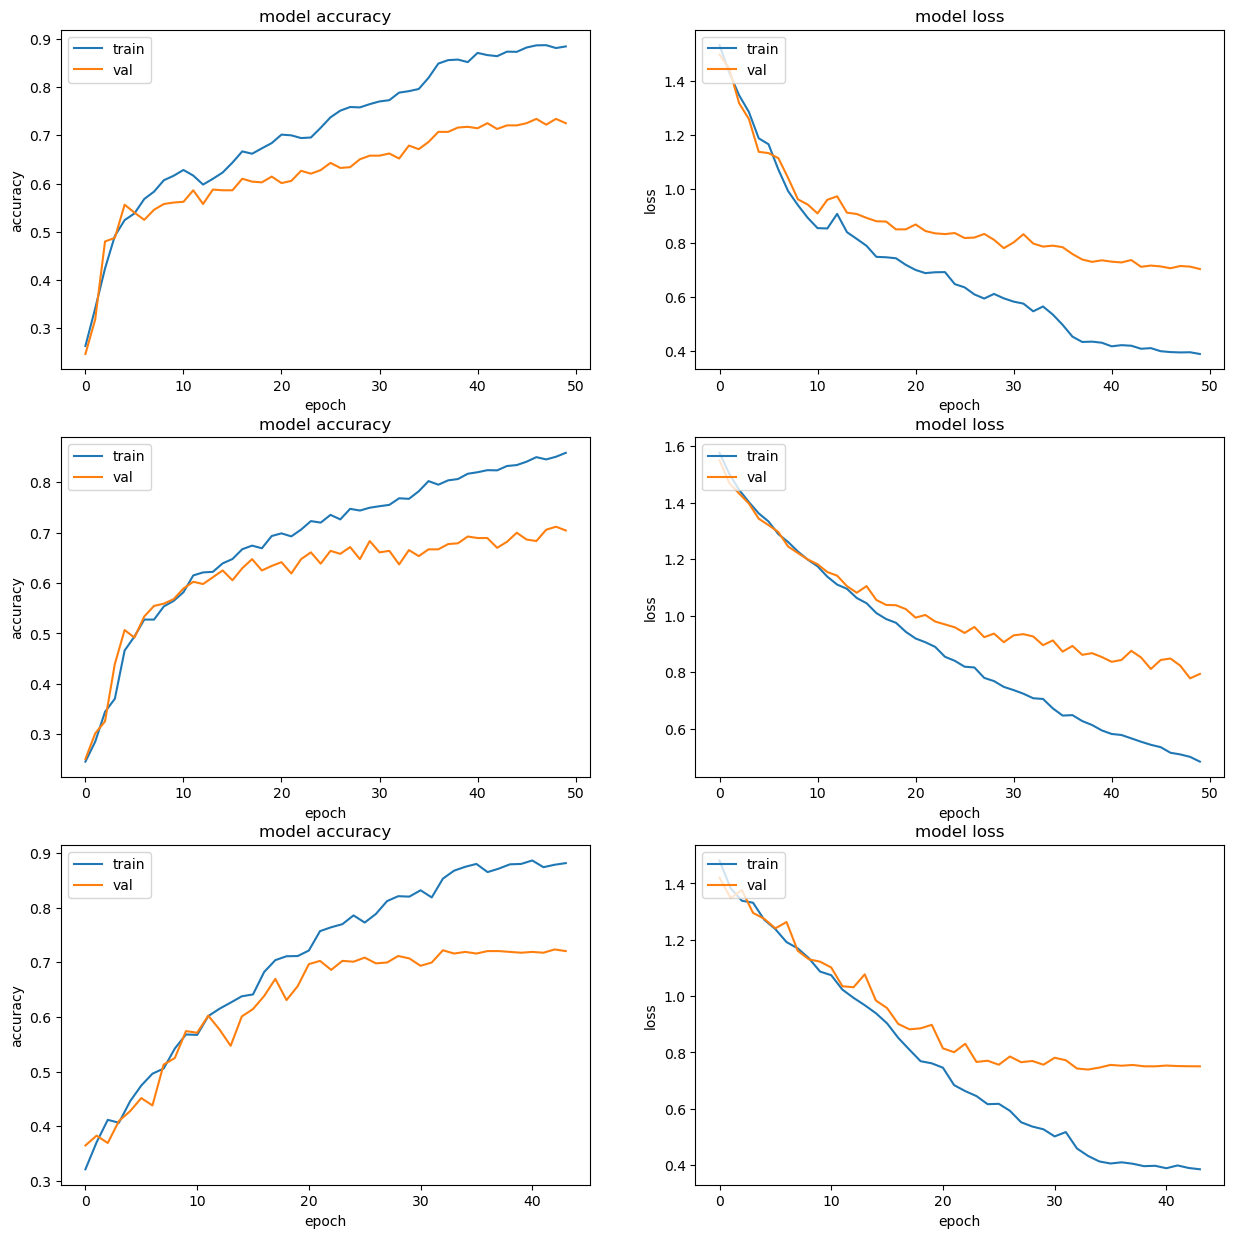

Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5627 - accuracy: 0.2640 - val_loss: 1.5065 - val_accuracy: 0.2466
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4642 - accuracy: 0.3239 - val_loss: 1.4555 - val_accuracy: 0.3154
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4096 - accuracy: 0.3541 - val_loss: 1.4234 - val_accuracy: 0.2840
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3126 - accuracy: 0.4256 - val_loss: 1.3168 - val_accuracy: 0.4858
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2973 - accuracy: 0.4799 - val_loss: 1.2707 - val_accuracy: 0.4963
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2592 - accuracy: 0.5067 - val_loss: 1.2304 - val_accuracy: 0.5471
Epoch 7/50
84/84 [==============================] - 1s 16ms/step - loss: 1.1897 - accuracy: 0.5846 - val_loss: 1.1748 - val_accuracy: 0.5710
Epoch 8/50
84

Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3665 - accuracy: 0.3910 - val_loss: 1.3733 - val_accuracy: 0.3842
Epoch 8/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3573 - accuracy: 0.3930 - val_loss: 1.3653 - val_accuracy: 0.3737
Epoch 9/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3319 - accuracy: 0.3894 - val_loss: 1.3516 - val_accuracy: 0.3677
Epoch 10/50
84/84 [==============================] - 1s 16ms/step - loss: 1.3301 - accuracy: 0.3726 - val_loss: 1.3516 - val_accuracy: 0.3752
Epoch 11/50
84/84 [==============================] - 1s 15ms/step - loss: 1.3255 - accuracy: 0.3624 - val_loss: 1.3348 - val_accuracy: 0.3587
Epoch 12/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2676 - accuracy: 0.4062 - val_loss: 1.3133 - val_accuracy: 0.3961
Epoch 13/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2871 - accuracy: 0.3921 - val_loss: 1.2940 - val_accuracy: 0.3707
Epoch 14/

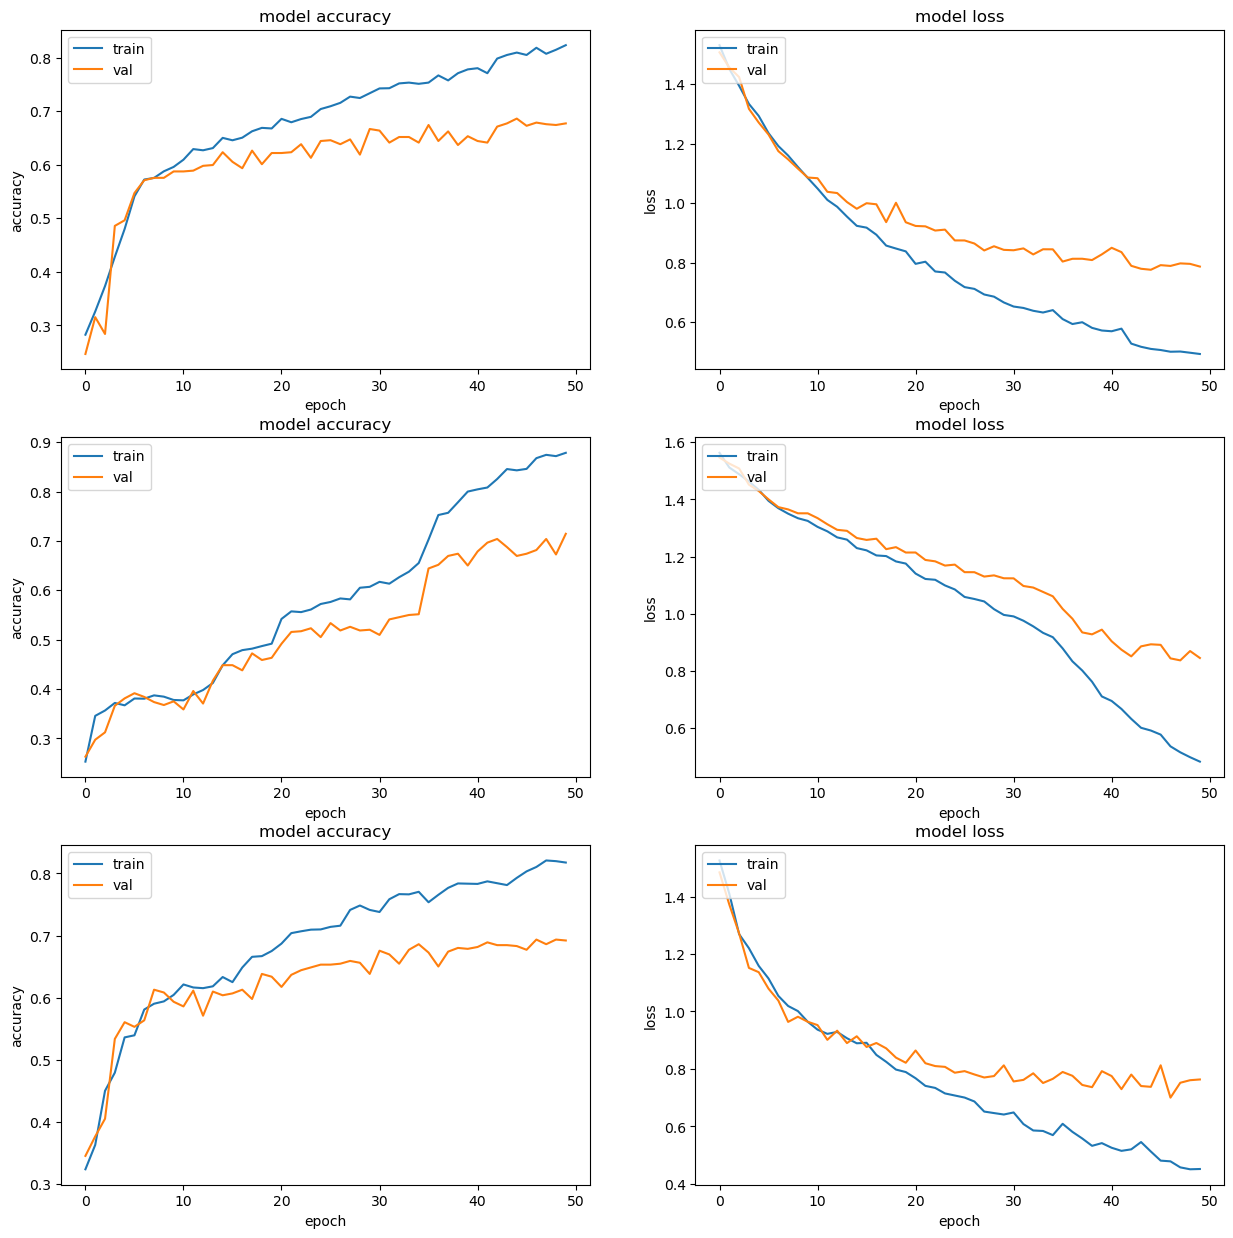

Epoch 1/50
84/84 [==============================] - 3s 20ms/step - loss: 1.5666 - accuracy: 0.2976 - val_loss: 1.5183 - val_accuracy: 0.3558
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 1.4632 - accuracy: 0.3700 - val_loss: 1.4361 - val_accuracy: 0.3901
Epoch 3/50
84/84 [==============================] - 1s 16ms/step - loss: 1.3969 - accuracy: 0.4068 - val_loss: 1.3608 - val_accuracy: 0.4230
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2953 - accuracy: 0.4542 - val_loss: 1.2401 - val_accuracy: 0.4499
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 1.2041 - accuracy: 0.4780 - val_loss: 1.1793 - val_accuracy: 0.4649
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 1.1480 - accuracy: 0.5348 - val_loss: 1.1319 - val_accuracy: 0.5471
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 1.0843 - accuracy: 0.5609 - val_loss: 1.0865 - val_accuracy: 0.5486
Epoch 8/50
84

Epoch 27/50
84/84 [==============================] - 1s 15ms/step - loss: 0.5052 - accuracy: 0.7928 - val_loss: 0.7490 - val_accuracy: 0.6876
Epoch 28/50
84/84 [==============================] - 1s 15ms/step - loss: 0.5226 - accuracy: 0.7907 - val_loss: 0.7505 - val_accuracy: 0.6876
Epoch 29/50
84/84 [==============================] - 1s 15ms/step - loss: 0.4908 - accuracy: 0.8120 - val_loss: 0.7242 - val_accuracy: 0.7040
Epoch 30/50
84/84 [==============================] - 1s 15ms/step - loss: 0.4746 - accuracy: 0.8127 - val_loss: 0.7381 - val_accuracy: 0.7085

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 31/50
84/84 [==============================] - 1s 15ms/step - loss: 0.4360 - accuracy: 0.8335 - val_loss: 0.7063 - val_accuracy: 0.7160
Epoch 32/50
84/84 [==============================] - 1s 16ms/step - loss: 0.4431 - accuracy: 0.8311 - val_loss: 0.7018 - val_accuracy: 0.7115
Epoch 33/50
84/84 [==============================] - 1s 16ms/step 

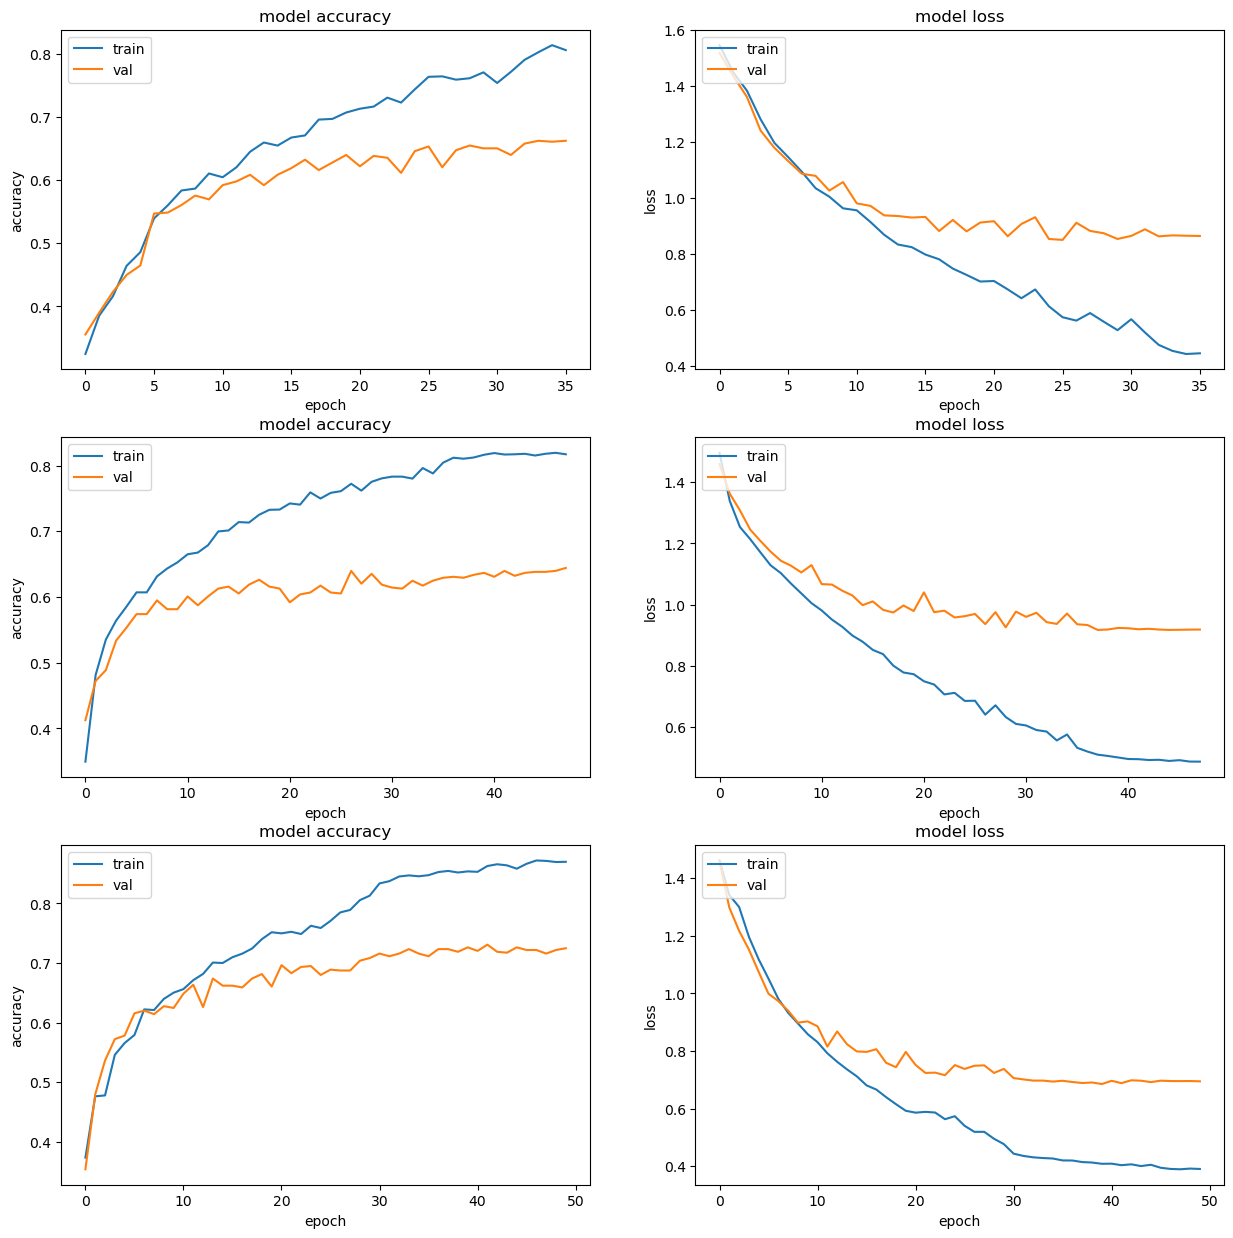

In [13]:
emodb2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# EMOVO

In [14]:
metadata, data0, data1, data2, data3, y = load_data('emovo')
metadata

path       filename  chunk  \
0     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
1     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      1   
2     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
3     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      1   
4     /datasets/nicolas_facchinetti/emovo/data/m3/gi...  gio-m3-l1.wav      0   
...                                                 ...            ...    ...   
4926  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4927  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4928  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4929  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   
4930  /datasets/nicolas_facchinetti/emovo/data/m2/pa...  pau-m2-b3.wav      0   

      label actor gender  mod  
0     happy    m3      m    0  
1     happy    m3      m    0  
2     happy    m3      m    1  
3     happy    m3      m    1  
4     happy    m3      m    1  
...     ...   ...    ...  ...  
4926   fear    m2      m    1  
4927   fear    m2      m    2  
4928   fear    m2      m    2  
4929   fear    m2      m    2  
4930   fear    m2      m    2  

[4931 rows x 7 columns]

In [15]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 261, 128, 1),
 (4931, 5))

## Without standardization

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6217 - accuracy: 0.1951 - val_loss: 1.6084 - val_accuracy: 0.2205
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6077 - accuracy: 0.2210 - val_loss: 1.6067 - val_accuracy: 0.2193
Epoch 3/50
99/99 [==============================] - 2s 16ms/step - loss: 1.6018 - accuracy: 0.2268 - val_loss: 1.6100 - val_accuracy: 0.2243
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6143 - accuracy: 0.2022 - val_loss: 1.6089 - val_accuracy: 0.2167
Epoch 5/50
99/99 [==============================] - 1s 15ms/step - loss: 1.5779 - accuracy: 0.2564 - val_loss: 1.5670 - val_accuracy: 0.2548
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5600 - accuracy: 0.2596 - val_loss: 1.5813 - val_accuracy: 0.2725
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5284 - accuracy: 0.2882 - val_loss: 1.5267 - val_accuracy: 0.3042
Epoch 8/50
99

99/99 [==============================] - 2s 16ms/step - loss: 1.6520 - accuracy: 0.2134 - val_loss: 1.6238 - val_accuracy: 0.2193
Epoch 14/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6268 - accuracy: 0.2277 - val_loss: 1.6130 - val_accuracy: 0.2193
Epoch 15/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6098 - accuracy: 0.2250 - val_loss: 1.6095 - val_accuracy: 0.2193

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6121 - accuracy: 0.2198 - val_loss: 1.6093 - val_accuracy: 0.2193
Epoch 17/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6092 - accuracy: 0.2250 - val_loss: 1.6092 - val_accuracy: 0.2193
Epoch 18/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6104 - accuracy: 0.2213 - val_loss: 1.6090 - val_accuracy: 0.2193
Epoch 19/50
99/99 [==============================] - 2s 15ms/step - loss: 1.60

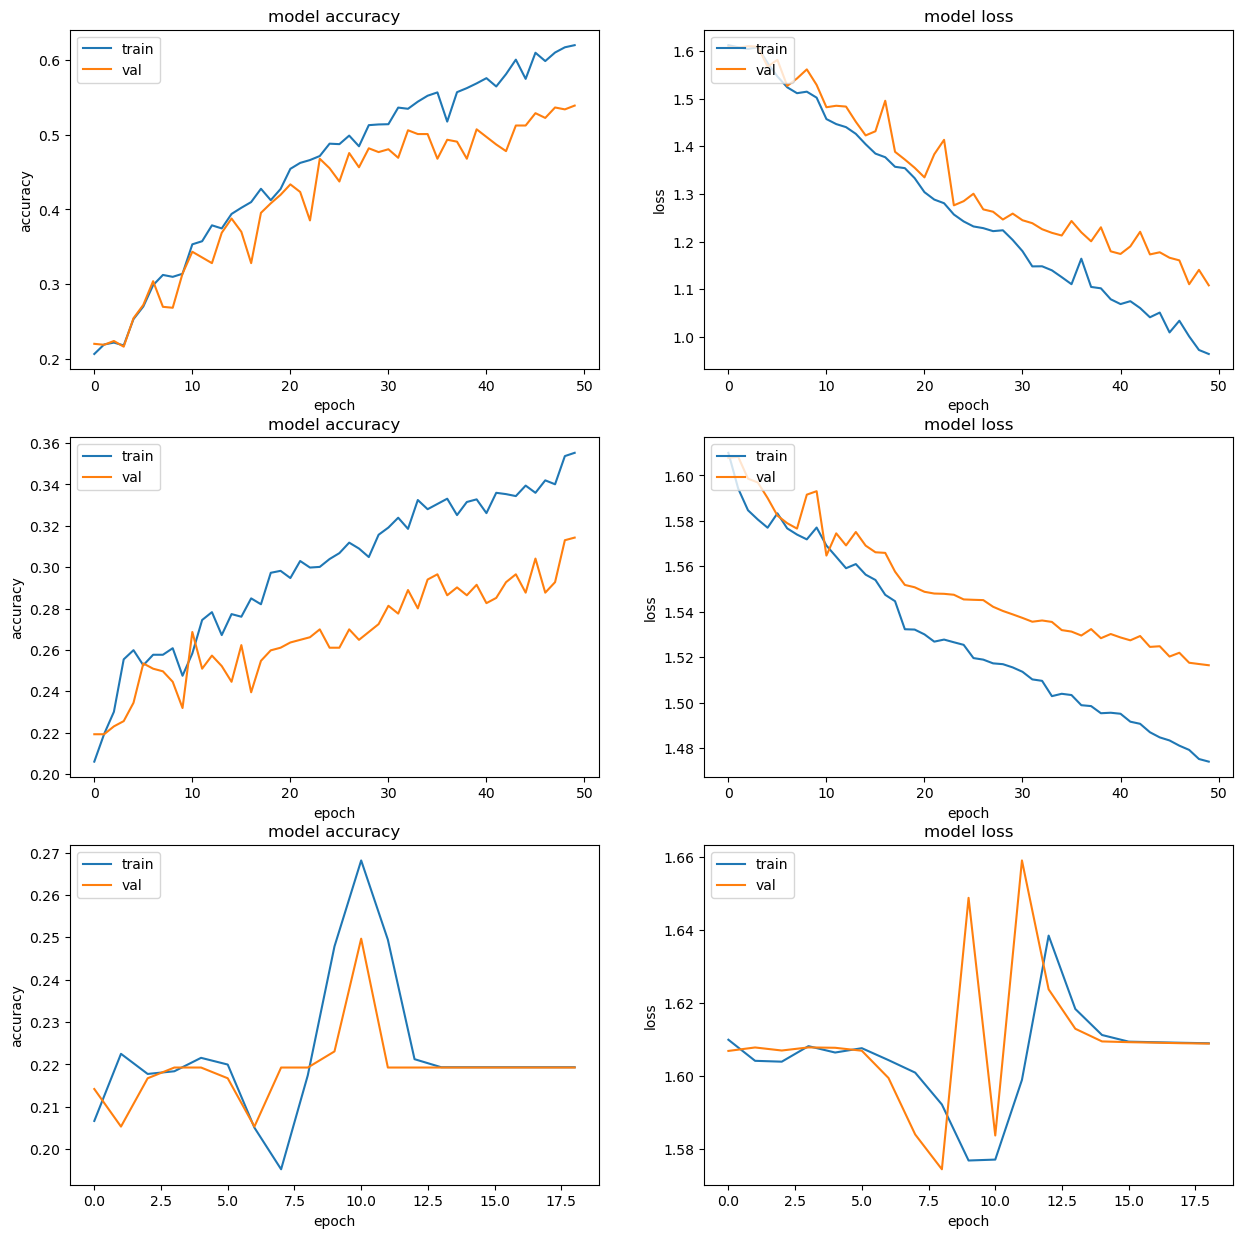

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6092 - accuracy: 0.2010 - val_loss: 1.6084 - val_accuracy: 0.2193
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6087 - accuracy: 0.2194 - val_loss: 1.6080 - val_accuracy: 0.2041
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5960 - accuracy: 0.2250 - val_loss: 1.6185 - val_accuracy: 0.2319
Epoch 4/50
99/99 [==============================] - 1s 15ms/step - loss: 1.5829 - accuracy: 0.2381 - val_loss: 1.6368 - val_accuracy: 0.1901
Epoch 5/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5628 - accuracy: 0.2427 - val_loss: 1.6063 - val_accuracy: 0.2269
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5442 - accuracy: 0.2929 - val_loss: 1.6348 - val_accuracy: 0.2167
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5186 - accuracy: 0.3254 - val_loss: 1.4944 - val_accuracy: 0.3384
Epoch 8/50
99

Epoch 6/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6083 - accuracy: 0.2155 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 7/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6068 - accuracy: 0.2202 - val_loss: 1.6079 - val_accuracy: 0.2193
Epoch 8/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6085 - accuracy: 0.2213 - val_loss: 1.6078 - val_accuracy: 0.2193

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6091 - accuracy: 0.2155 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 10/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6090 - accuracy: 0.2061 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 11/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6079 - accuracy: 0.2230 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 12/50
99/99 [==============================] - 1s 15ms/step - lo

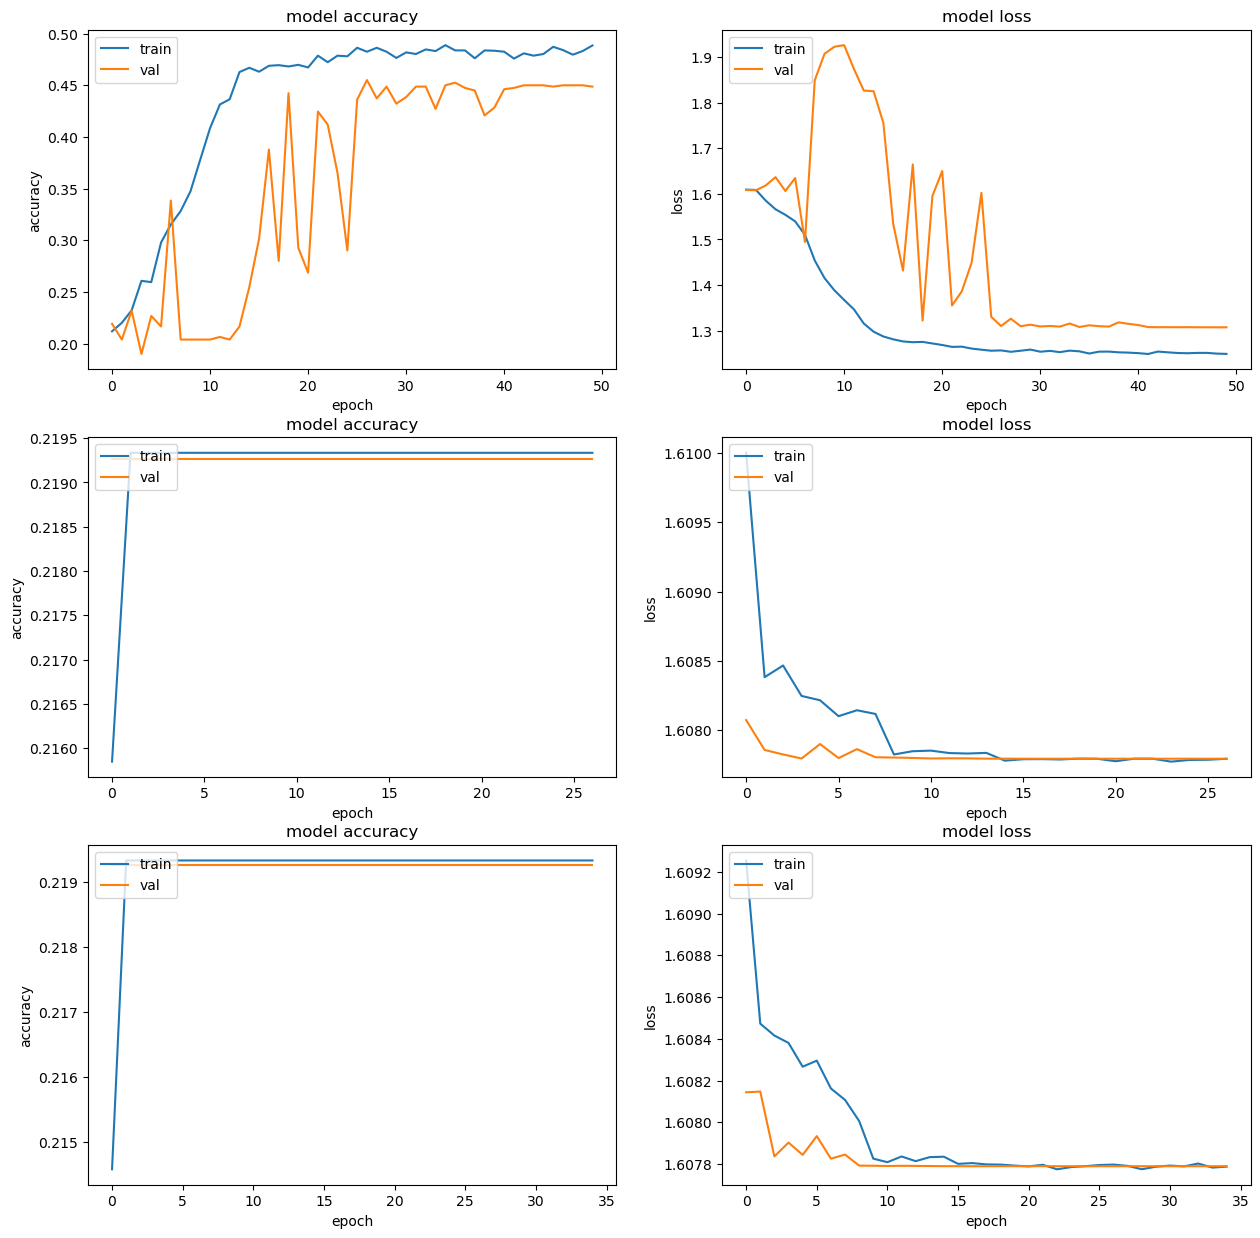

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.5839 - accuracy: 0.2193 - val_loss: 1.6024 - val_accuracy: 0.2433
Epoch 2/50
99/99 [==============================] - 2s 16ms/step - loss: 1.5345 - accuracy: 0.2818 - val_loss: 1.5763 - val_accuracy: 0.2966
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4964 - accuracy: 0.3554 - val_loss: 1.5085 - val_accuracy: 0.3245
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4544 - accuracy: 0.3638 - val_loss: 1.5278 - val_accuracy: 0.3169
Epoch 5/50
99/99 [==============================] - 2s 19ms/step - loss: 1.4390 - accuracy: 0.3786 - val_loss: 1.5488 - val_accuracy: 0.3371
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4120 - accuracy: 0.4058 - val_loss: 1.4590 - val_accuracy: 0.3904
Epoch 7/50
99/99 [==============================] - 1s 15ms/step - loss: 1.3854 - accuracy: 0.4192 - val_loss: 1.4701 - val_accuracy: 0.3904
Epoch 8/50
99

Epoch 7/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6079 - accuracy: 0.2160 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 8/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6088 - accuracy: 0.2063 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 9/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6067 - accuracy: 0.2252 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 10/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6069 - accuracy: 0.2259 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 11/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6081 - accuracy: 0.2201 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 12/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6078 - accuracy: 0.2152 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 13/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6071 - accuracy: 0.2173 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 14/

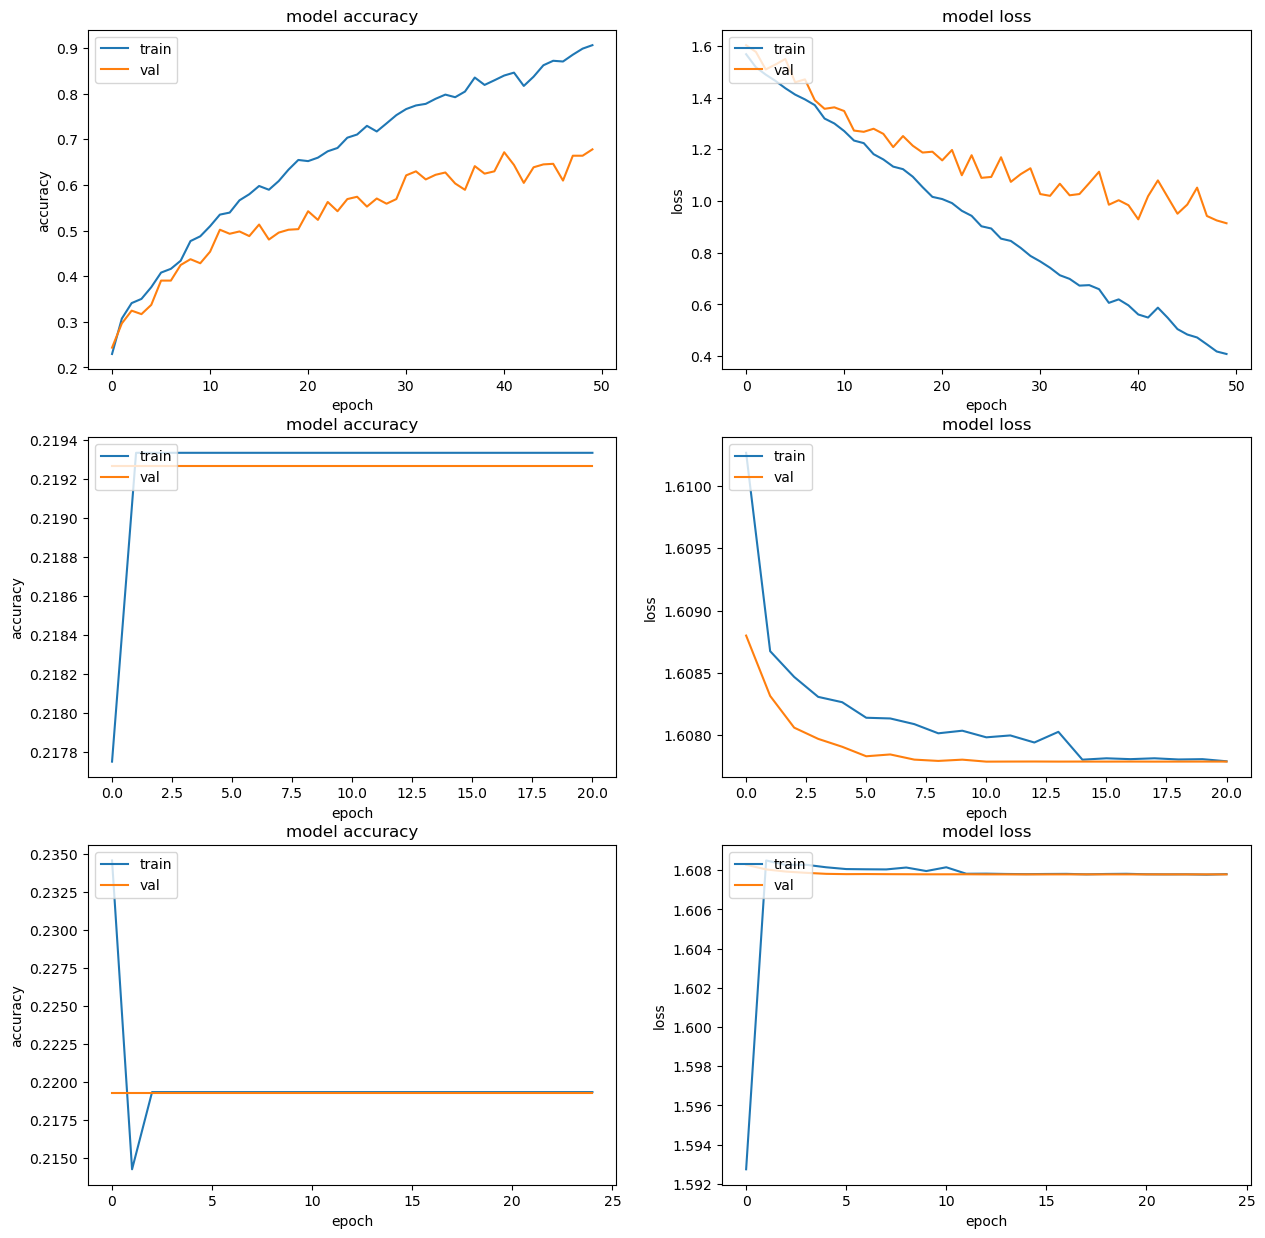

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6041 - accuracy: 0.2190 - val_loss: 1.5988 - val_accuracy: 0.2193
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5899 - accuracy: 0.2313 - val_loss: 1.5829 - val_accuracy: 0.2231
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5831 - accuracy: 0.2426 - val_loss: 1.5951 - val_accuracy: 0.2370
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5573 - accuracy: 0.2624 - val_loss: 1.5624 - val_accuracy: 0.2560
Epoch 5/50
99/99 [==============================] - 1s 15ms/step - loss: 1.5404 - accuracy: 0.2716 - val_loss: 1.5542 - val_accuracy: 0.2510
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5348 - accuracy: 0.2699 - val_loss: 1.5488 - val_accuracy: 0.2421
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5227 - accuracy: 0.2935 - val_loss: 1.5233 - val_accuracy: 0.2725
Epoch 8/50
99

Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5113 - accuracy: 0.3365 - val_loss: 1.5249 - val_accuracy: 0.2940
Epoch 8/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4800 - accuracy: 0.3496 - val_loss: 1.4999 - val_accuracy: 0.3207
Epoch 9/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4357 - accuracy: 0.3975 - val_loss: 1.4911 - val_accuracy: 0.3232
Epoch 10/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4291 - accuracy: 0.3987 - val_loss: 1.4672 - val_accuracy: 0.3460
Epoch 11/50
99/99 [==============================] - 2s 15ms/step - loss: 1.3706 - accuracy: 0.4428 - val_loss: 1.4327 - val_accuracy: 0.3612
Epoch 12/50
99/99 [==============================] - 2s 15ms/step - loss: 1.3341 - accuracy: 0.4673 - val_loss: 1.4156 - val_accuracy: 0.3891
Epoch 13/50
99/99 [==============================] - 2s 15ms/step - loss: 1.2850 - accuracy: 0.5139 - val_loss: 1.3836 - val_accuracy: 0.4297
Epoch 14/

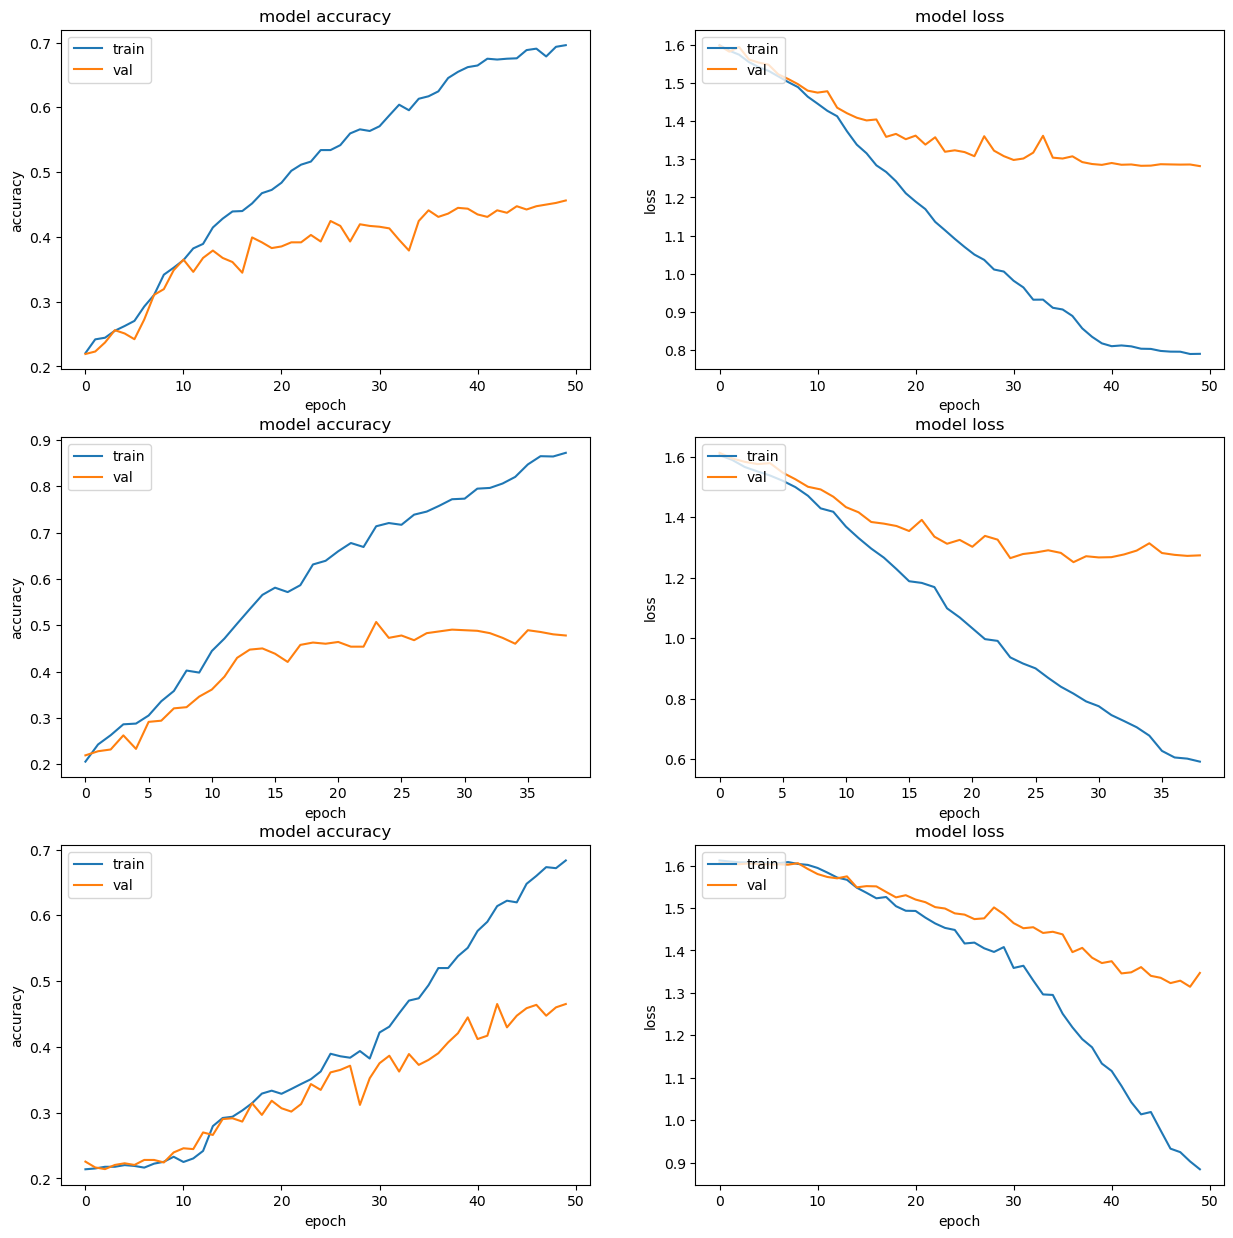

In [16]:
emovo1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [17]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6097 - accuracy: 0.2276 - val_loss: 1.5871 - val_accuracy: 0.2269
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5856 - accuracy: 0.2427 - val_loss: 1.5546 - val_accuracy: 0.2433
Epoch 3/50
99/99 [==============================] - 1s 15ms/step - loss: 1.5712 - accuracy: 0.2517 - val_loss: 1.5509 - val_accuracy: 0.2636
Epoch 4/50
99/99 [==============================] - 1s 15ms/step - loss: 1.5418 - accuracy: 0.3051 - val_loss: 1.5297 - val_accuracy: 0.3194
Epoch 5/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5072 - accuracy: 0.3441 - val_loss: 1.5299 - val_accuracy: 0.3169
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4920 - accuracy: 0.3434 - val_loss: 1.5254 - val_accuracy: 0.3295
Epoch 7/50
99/99 [==============================] - 1s 15ms/step - loss: 1.4940 - accuracy: 0.3323 - val_loss: 1.4922 - val_accuracy: 0.3143
Epoch 8/50
99

99/99 [==============================] - 2s 15ms/step - loss: 1.4650 - accuracy: 0.3305 - val_loss: 1.4743 - val_accuracy: 0.3561
Epoch 14/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4683 - accuracy: 0.3464 - val_loss: 1.4600 - val_accuracy: 0.3726
Epoch 15/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4467 - accuracy: 0.3508 - val_loss: 1.4532 - val_accuracy: 0.3498
Epoch 16/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4364 - accuracy: 0.3576 - val_loss: 1.4556 - val_accuracy: 0.3447
Epoch 17/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4131 - accuracy: 0.3852 - val_loss: 1.4174 - val_accuracy: 0.3878
Epoch 18/50
99/99 [==============================] - 1s 15ms/step - loss: 1.4291 - accuracy: 0.3694 - val_loss: 1.4299 - val_accuracy: 0.3549
Epoch 19/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4051 - accuracy: 0.3817 - val_loss: 1.4320 - val_accuracy: 0.3549
Epoch 20/50
99/99 

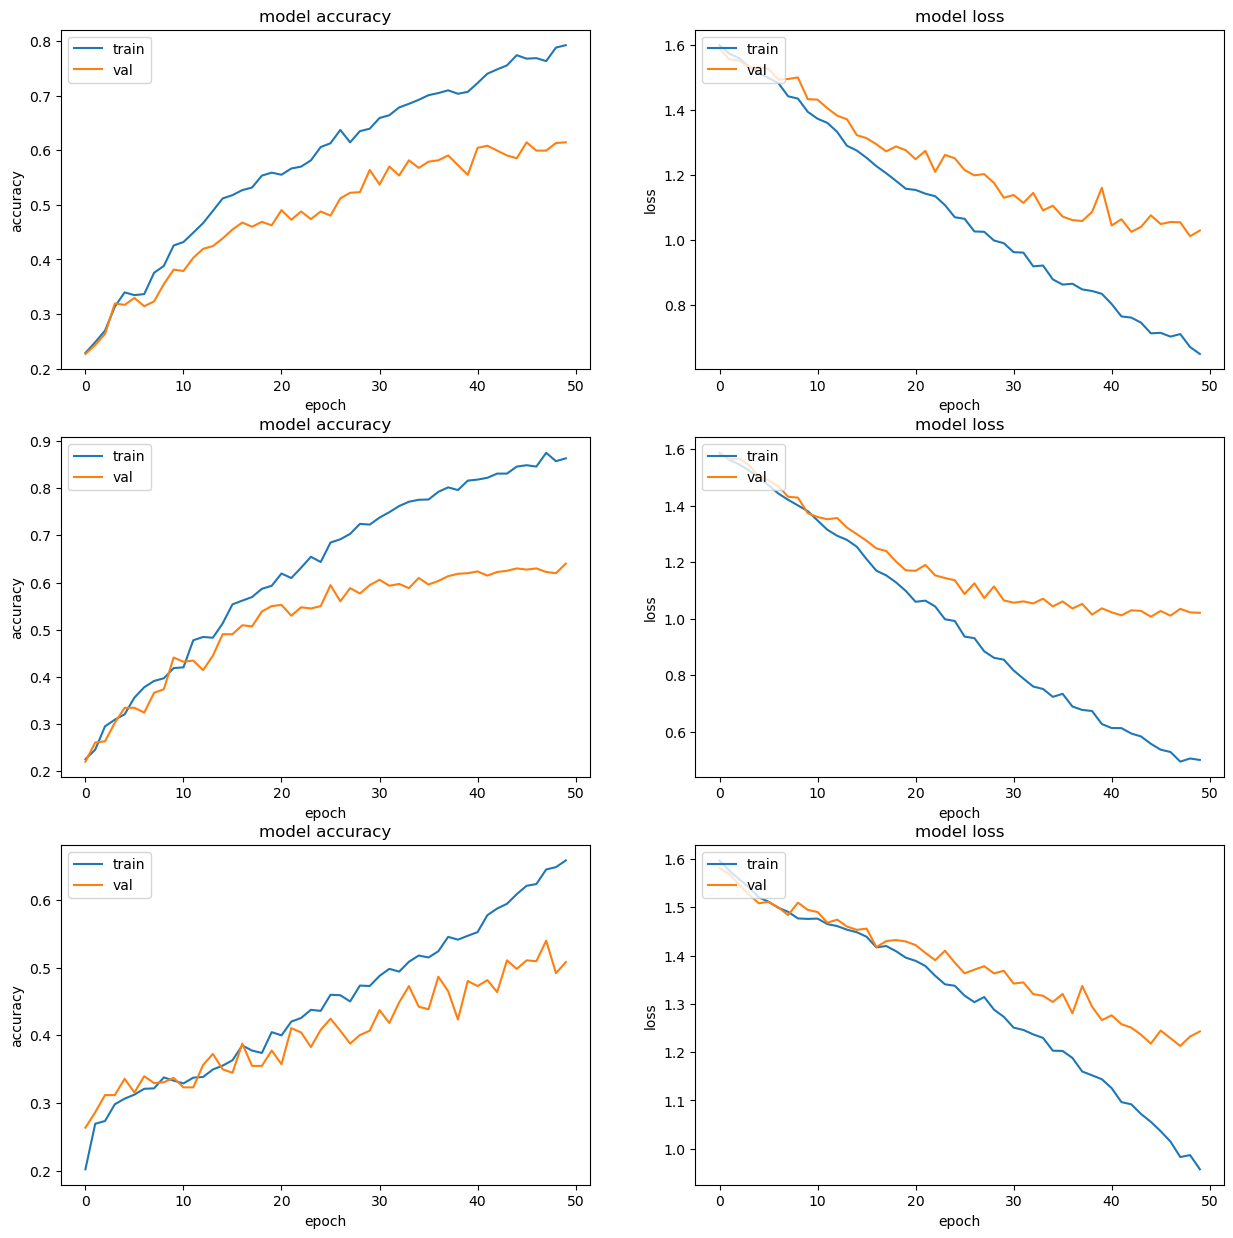

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6105 - accuracy: 0.1982 - val_loss: 1.5757 - val_accuracy: 0.2890
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5806 - accuracy: 0.2915 - val_loss: 1.5412 - val_accuracy: 0.2928
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5049 - accuracy: 0.3568 - val_loss: 1.4952 - val_accuracy: 0.3422
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4743 - accuracy: 0.3615 - val_loss: 1.4367 - val_accuracy: 0.3891
Epoch 5/50
99/99 [==============================] - 1s 15ms/step - loss: 1.4146 - accuracy: 0.4080 - val_loss: 1.4148 - val_accuracy: 0.3992
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4042 - accuracy: 0.4051 - val_loss: 1.3779 - val_accuracy: 0.4246
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.3587 - accuracy: 0.4367 - val_loss: 1.3600 - val_accuracy: 0.4183
Epoch 8/50
99

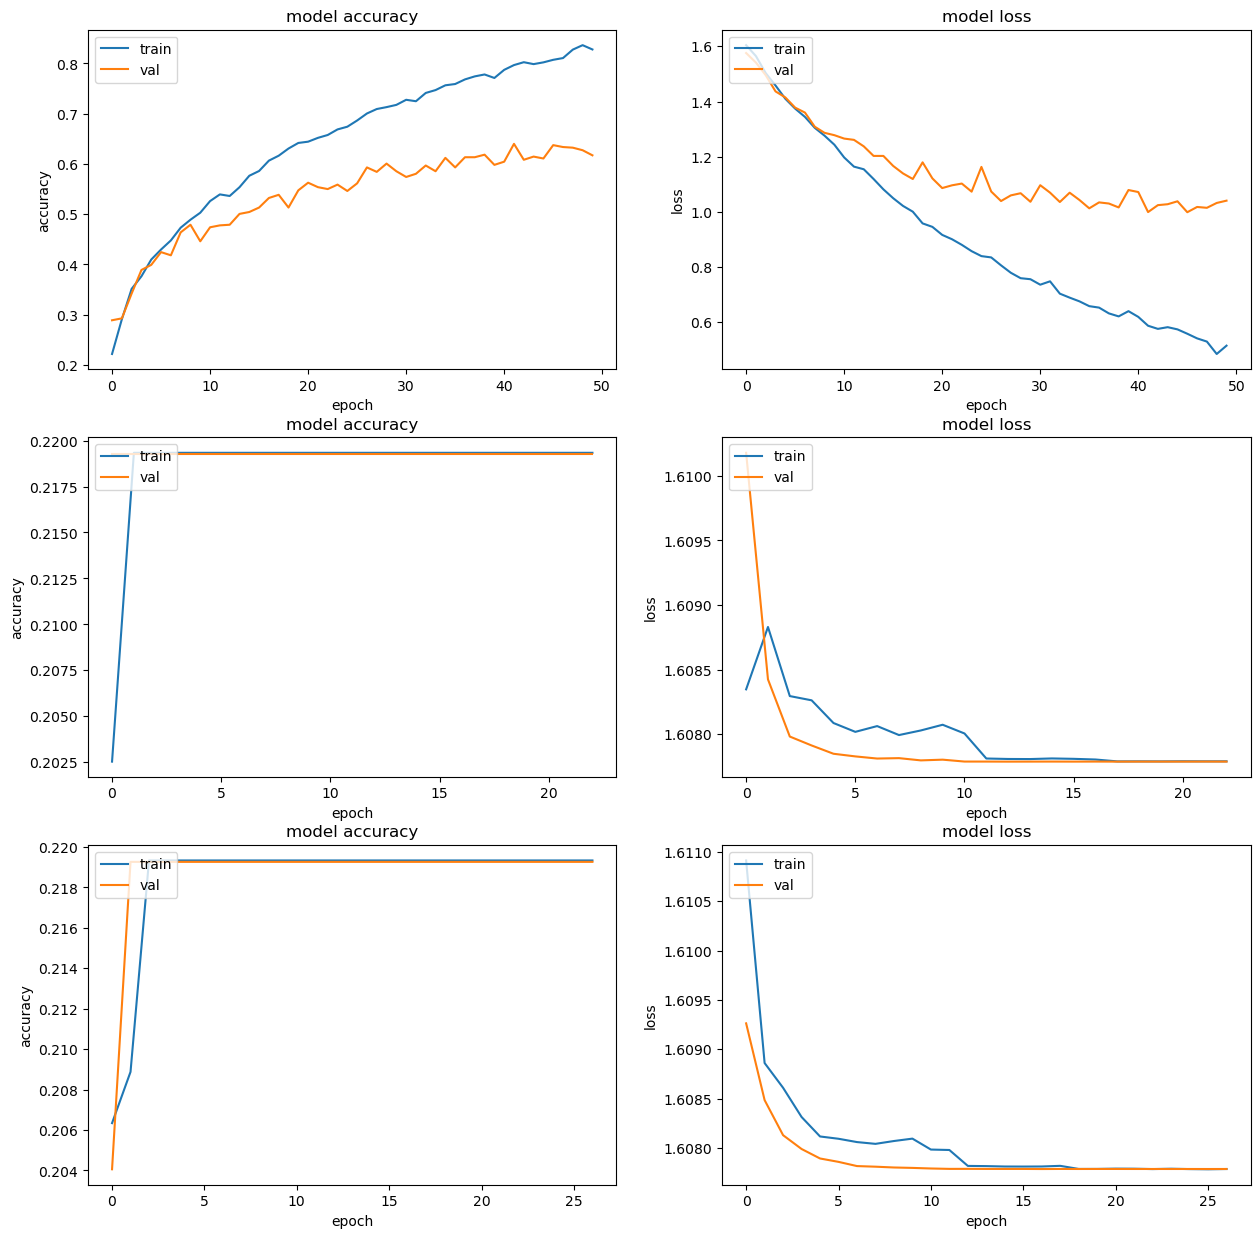

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6142 - accuracy: 0.2042 - val_loss: 1.6083 - val_accuracy: 0.2180
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6080 - accuracy: 0.2131 - val_loss: 1.6084 - val_accuracy: 0.2193
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6082 - accuracy: 0.1950 - val_loss: 1.6081 - val_accuracy: 0.2193
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6086 - accuracy: 0.2238 - val_loss: 1.6080 - val_accuracy: 0.2193
Epoch 5/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6078 - accuracy: 0.2259 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 6/50
99/99 [==============================] - 2s 16ms/step - loss: 1.6079 - accuracy: 0.2138 - val_loss: 1.6077 - val_accuracy: 0.2193
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6072 - accuracy: 0.2114 - val_loss: 1.6079 - val_accuracy: 0.2193
Epoch 8/50
99

Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6077 - accuracy: 0.2199 - val_loss: 1.6079 - val_accuracy: 0.2193
Epoch 7/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6063 - accuracy: 0.2338 - val_loss: 1.6079 - val_accuracy: 0.2193
Epoch 8/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6079 - accuracy: 0.2217 - val_loss: 1.6079 - val_accuracy: 0.2193
Epoch 9/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6084 - accuracy: 0.2170 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 10/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6076 - accuracy: 0.2234 - val_loss: 1.6078 - val_accuracy: 0.2193

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
99/99 [==============================] - 1s 15ms/step - loss: 1.6076 - accuracy: 0.2204 - val_loss: 1.6078 - val_accuracy: 0.2193
Epoch 12/50
99/99 [==============================] - 1s 15ms/step - lo

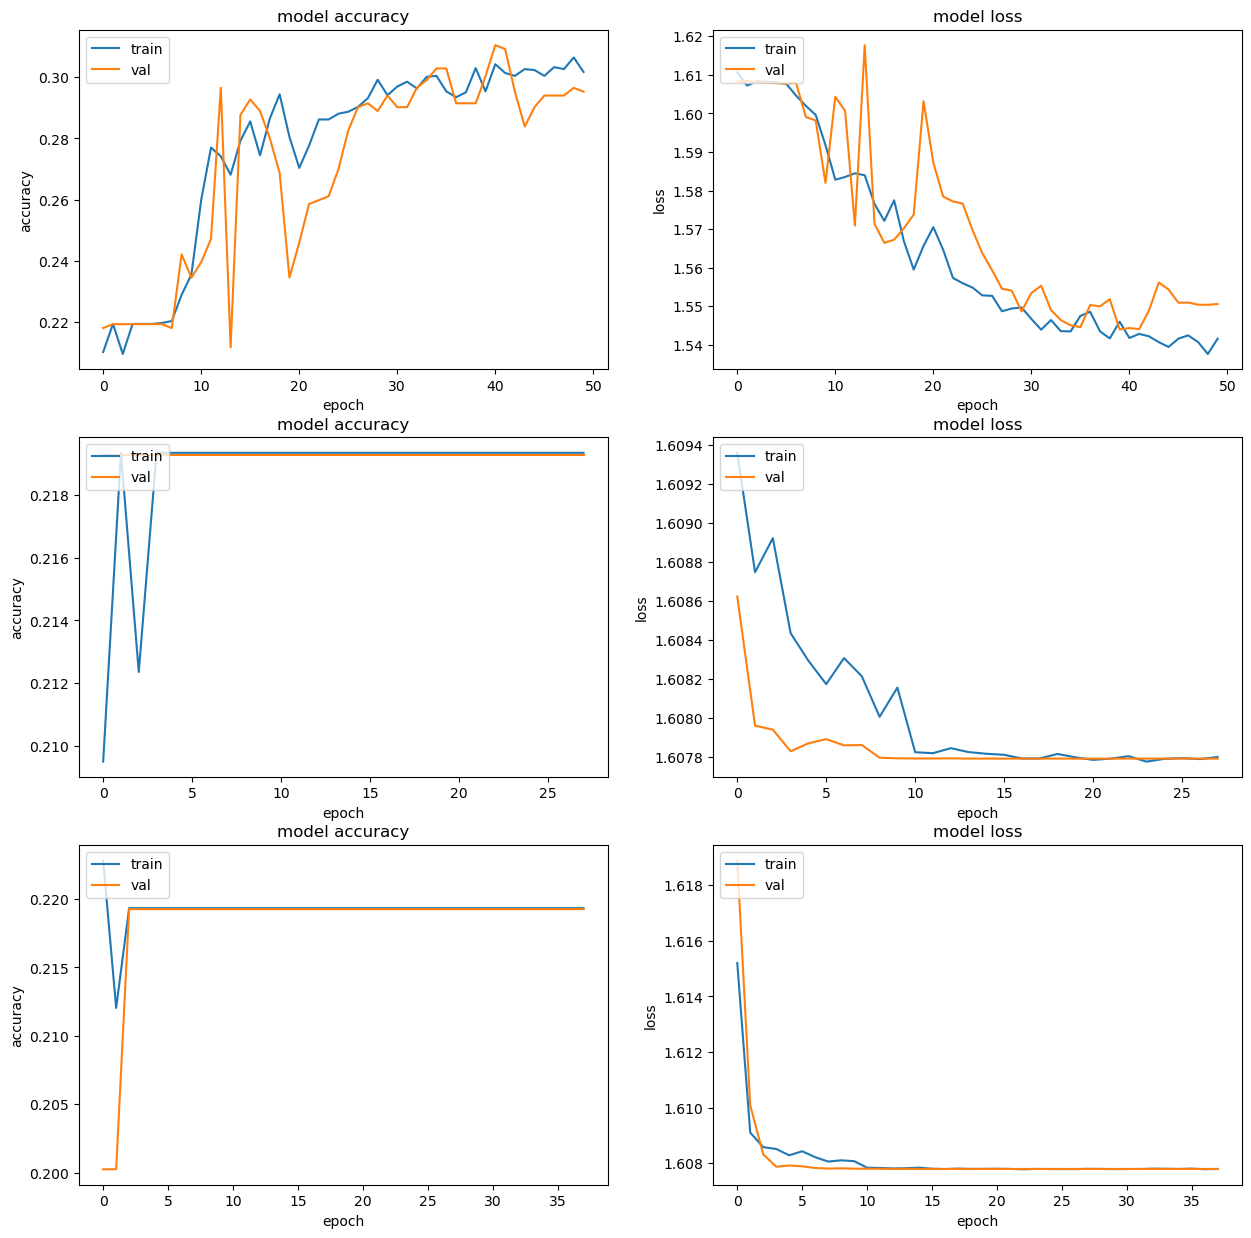

Epoch 1/50
99/99 [==============================] - 3s 19ms/step - loss: 1.6050 - accuracy: 0.2227 - val_loss: 1.6069 - val_accuracy: 0.2028
Epoch 2/50
99/99 [==============================] - 2s 15ms/step - loss: 1.6079 - accuracy: 0.2298 - val_loss: 1.6040 - val_accuracy: 0.1888
Epoch 3/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5995 - accuracy: 0.2155 - val_loss: 1.5954 - val_accuracy: 0.2345
Epoch 4/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5832 - accuracy: 0.2284 - val_loss: 1.6015 - val_accuracy: 0.2345
Epoch 5/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5787 - accuracy: 0.2528 - val_loss: 1.6022 - val_accuracy: 0.3219
Epoch 6/50
99/99 [==============================] - 2s 15ms/step - loss: 1.5497 - accuracy: 0.3183 - val_loss: 1.5285 - val_accuracy: 0.2940
Epoch 7/50
99/99 [==============================] - 2s 15ms/step - loss: 1.4785 - accuracy: 0.3570 - val_loss: 1.5014 - val_accuracy: 0.3093
Epoch 8/50
99

Epoch 11/50
99/99 [==============================] - 2s 15ms/step - loss: 1.2438 - accuracy: 0.4997 - val_loss: 1.3179 - val_accuracy: 0.4487
Epoch 12/50
99/99 [==============================] - 1s 15ms/step - loss: 1.2007 - accuracy: 0.5341 - val_loss: 1.2966 - val_accuracy: 0.4588
Epoch 13/50
99/99 [==============================] - 1s 15ms/step - loss: 1.1547 - accuracy: 0.5561 - val_loss: 1.2597 - val_accuracy: 0.4918
Epoch 14/50
99/99 [==============================] - 1s 15ms/step - loss: 1.1230 - accuracy: 0.5580 - val_loss: 1.2713 - val_accuracy: 0.4918
Epoch 15/50
99/99 [==============================] - 1s 15ms/step - loss: 1.0843 - accuracy: 0.6134 - val_loss: 1.2577 - val_accuracy: 0.4778
Epoch 16/50
99/99 [==============================] - 2s 15ms/step - loss: 1.0565 - accuracy: 0.6200 - val_loss: 1.2286 - val_accuracy: 0.4918
Epoch 17/50
99/99 [==============================] - 2s 16ms/step - loss: 1.0262 - accuracy: 0.6262 - val_loss: 1.2303 - val_accuracy: 0.4956
Epoch 

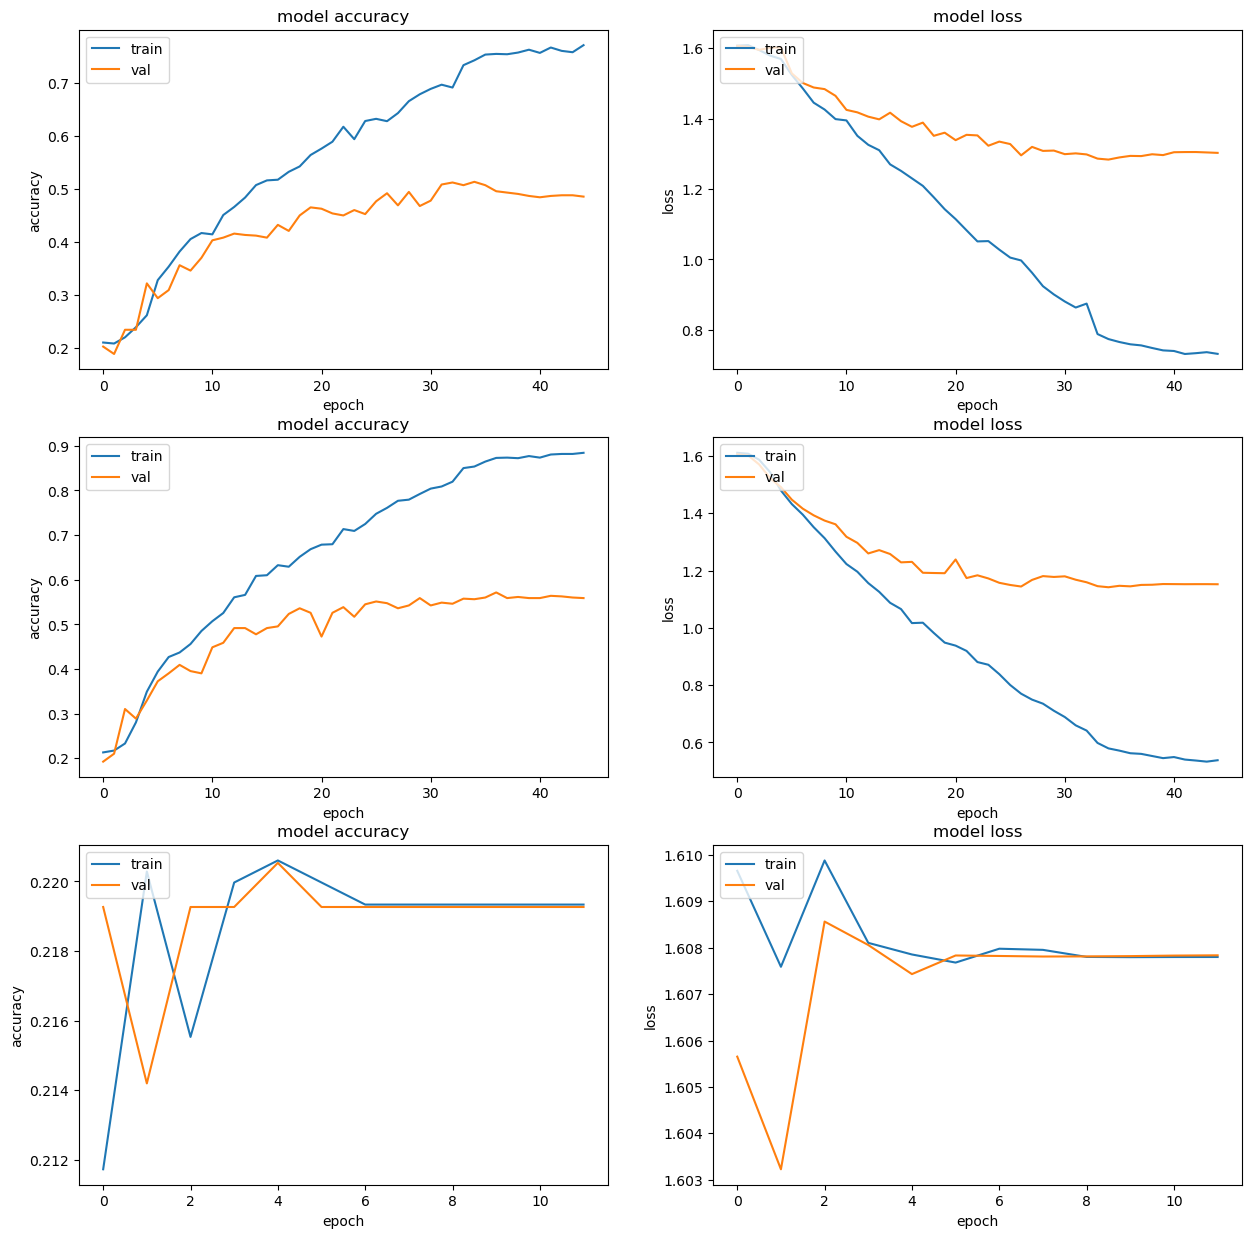

In [18]:
emovo2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# RAVDESS

In [19]:
metadata, data0, data1, data2, data3, y = load_data('ravdess')
metadata

path  \
0     /datasets/nicolas_facchinetti/ravdess/data/Act...   
1     /datasets/nicolas_facchinetti/ravdess/data/Act...   
2     /datasets/nicolas_facchinetti/ravdess/data/Act...   
3     /datasets/nicolas_facchinetti/ravdess/data/Act...   
4     /datasets/nicolas_facchinetti/ravdess/data/Act...   
...                                                 ...   
8947  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8948  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8949  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8950  /datasets/nicolas_facchinetti/ravdess/data/Act...   
8951  /datasets/nicolas_facchinetti/ravdess/data/Act...   

                      filename  chunk      label     actor gender  mod  
0     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    0  
1     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
2     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
3     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
4     03-01-08-01-02-02-15.wav      0  surprised  Actor_15      m    1  
...                        ...    ...        ...       ...    ...  ...  
8947  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    1  
8948  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8949  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8950  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  
8951  03-01-07-01-01-02-13.wav      0    disgust  Actor_13      m    2  

[8952 rows x 7 columns]

In [20]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 261, 128, 1),
 (8952, 5))

## Without standardization

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.5896 - accuracy: 0.2846 - val_loss: 1.5387 - val_accuracy: 0.2917
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5509 - accuracy: 0.3025 - val_loss: 1.5077 - val_accuracy: 0.3175
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5229 - accuracy: 0.3275 - val_loss: 1.4951 - val_accuracy: 0.3405
Epoch 4/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5124 - accuracy: 0.3438 - val_loss: 1.4911 - val_accuracy: 0.3378
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5012 - accuracy: 0.3441 - val_loss: 1.4982 - val_accuracy: 0.3426
Epoch 6/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4700 - accuracy: 0.3672 - val_loss: 1.4711 - val_accuracy: 0.3503
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4560 - accuracy: 0.3783 - val_loss: 1.4931 - val_accuracy: 0.3538

Epoch 12/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4865 - accuracy: 0.3088 - val_loss: 1.4747 - val_accuracy: 0.3175
Epoch 13/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4830 - accuracy: 0.3240 - val_loss: 1.5143 - val_accuracy: 0.3064
Epoch 14/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4869 - accuracy: 0.3108 - val_loss: 1.4809 - val_accuracy: 0.3126
Epoch 15/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4706 - accuracy: 0.3210 - val_loss: 1.4942 - val_accuracy: 0.3245
Epoch 16/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4794 - accuracy: 0.3244 - val_loss: 1.4717 - val_accuracy: 0.3182
Epoch 17/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4586 - accuracy: 0.3222 - val_loss: 1.4632 - val_accuracy: 0.3231
Epoch 18/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4664 - accuracy: 0.3193 - val_loss: 1.4918 - val_accuracy:

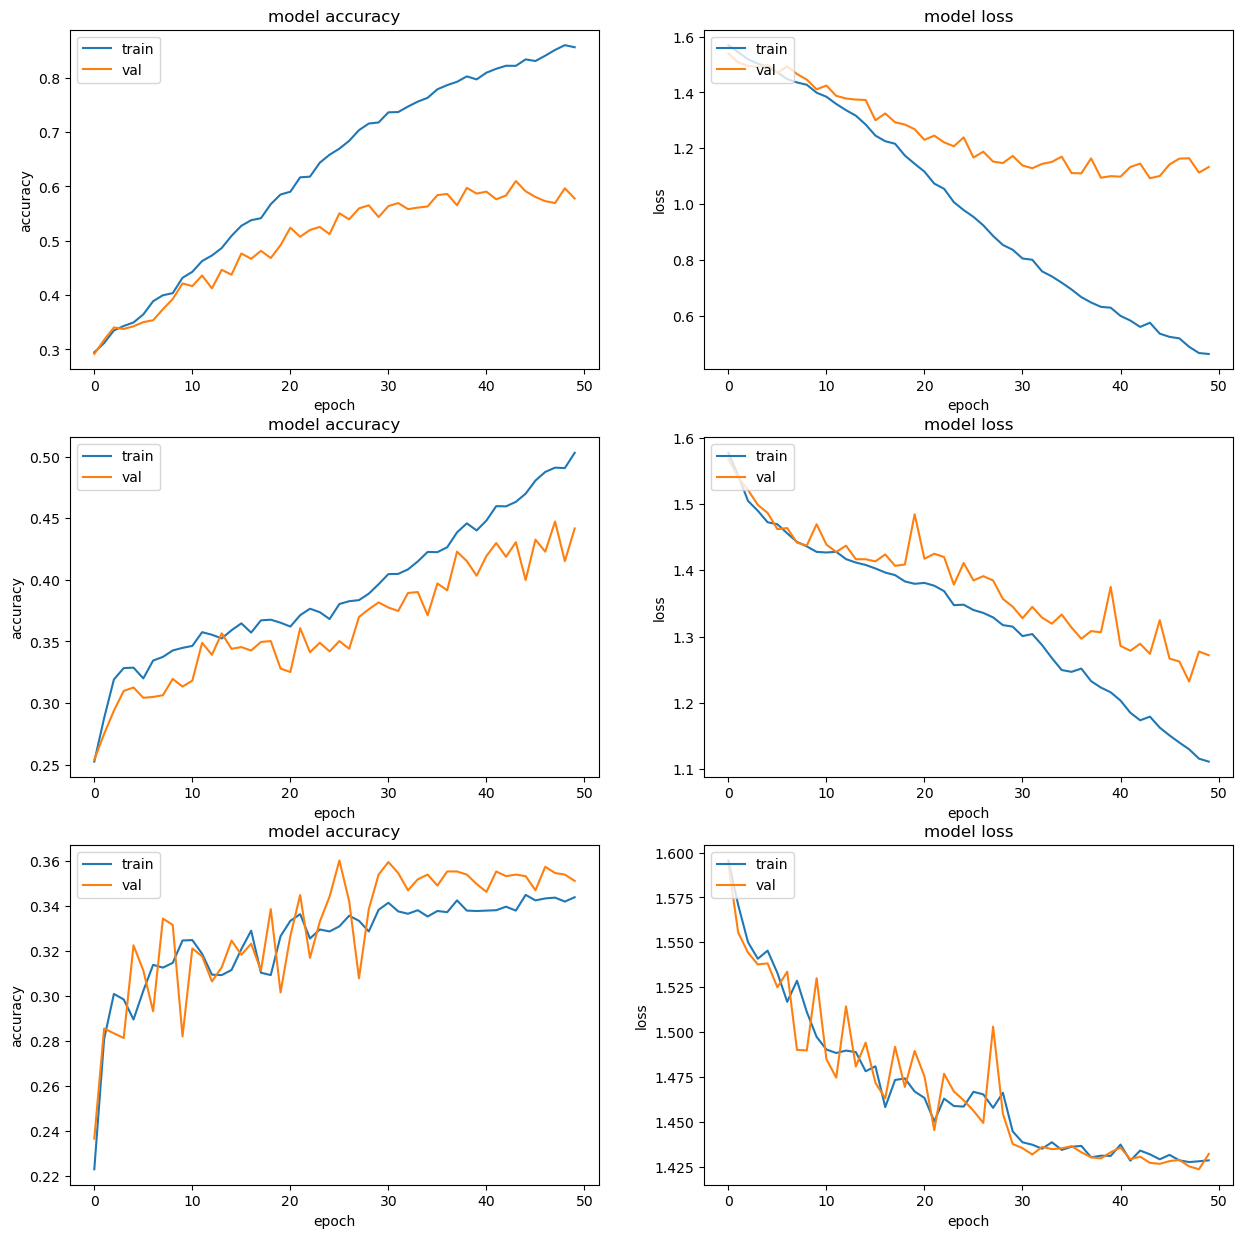

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.6074 - accuracy: 0.2111 - val_loss: 1.6094 - val_accuracy: 0.2066
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.2094 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.1844 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6093 - accuracy: 0.2123 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.2056 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6091 - accuracy: 0.2081 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6097 - accuracy: 0.2016 - val_loss: 1.6092 - val_accuracy: 0.2066

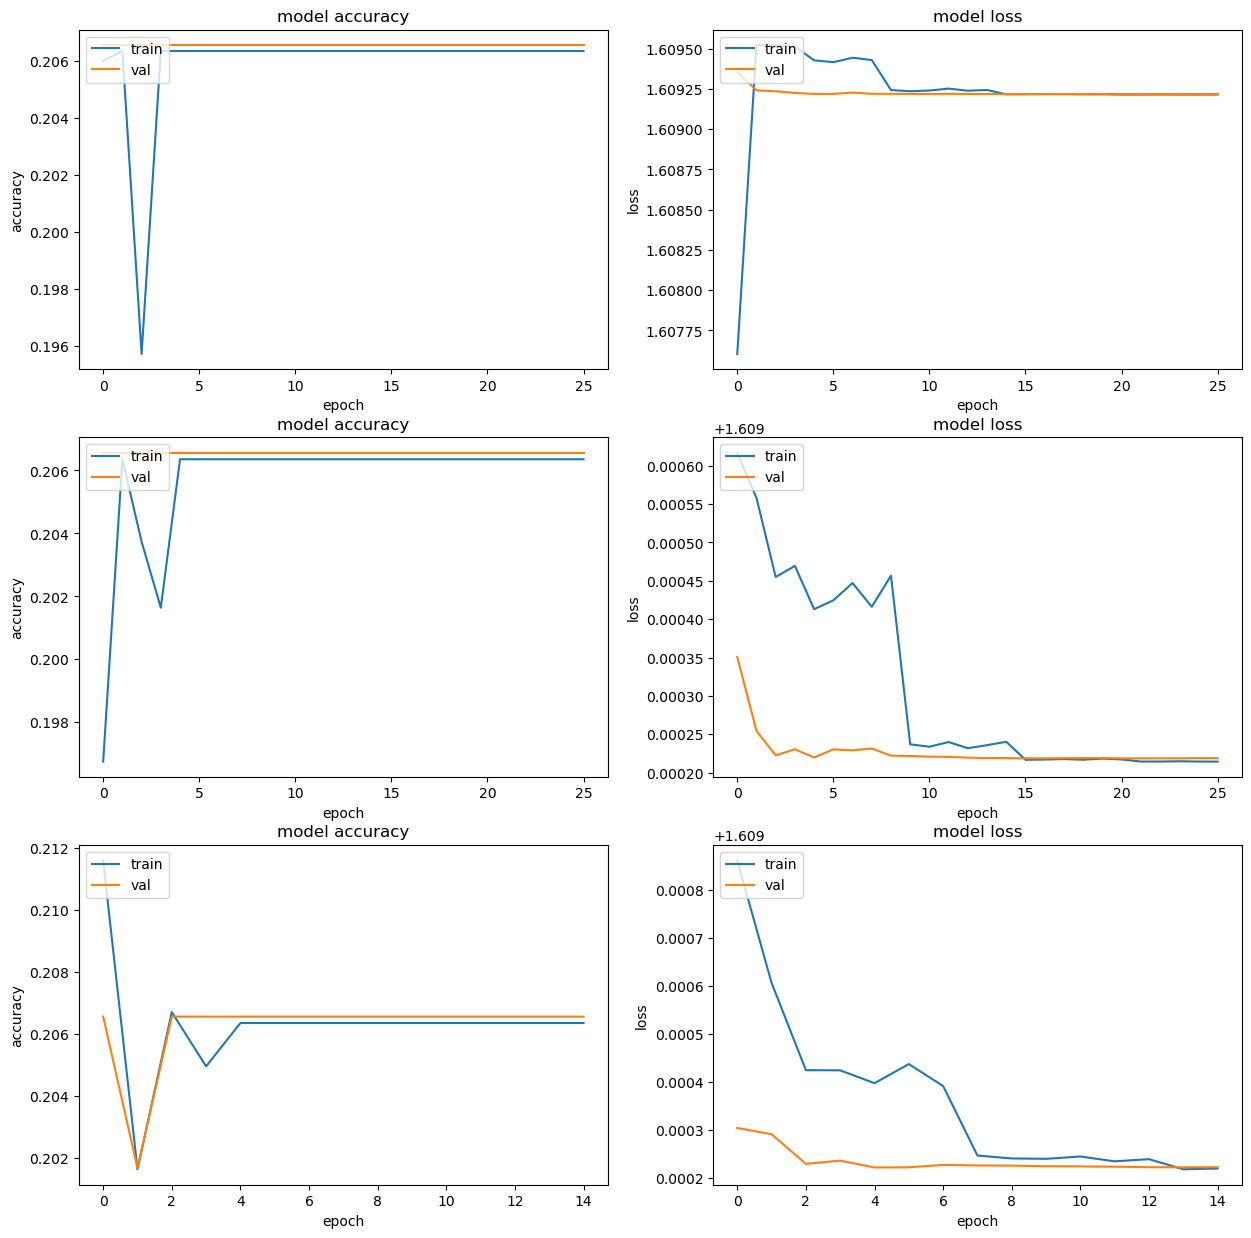

Epoch 1/50
179/179 [==============================] - 3s 15ms/step - loss: 1.5977 - accuracy: 0.2515 - val_loss: 1.6112 - val_accuracy: 0.2017
Epoch 2/50
179/179 [==============================] - 3s 16ms/step - loss: 1.6096 - accuracy: 0.2027 - val_loss: 1.6093 - val_accuracy: 0.2017
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6093 - accuracy: 0.2011 - val_loss: 1.6093 - val_accuracy: 0.2066
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6096 - accuracy: 0.2007 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6097 - accuracy: 0.1981 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.2053 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6093 - accuracy: 0.2104 - val_loss: 1.6092 - val_accuracy: 0.2066

179/179 [==============================] - 2s 12ms/step - loss: 1.6097 - accuracy: 0.2052 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 18/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6089 - accuracy: 0.2136 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 19/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6093 - accuracy: 0.2029 - val_loss: 1.6092 - val_accuracy: 0.2066

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6092 - accuracy: 0.2007 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 21/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6088 - accuracy: 0.2122 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 22/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6087 - accuracy: 0.2159 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 23/50
179/179 [==============================] - 2s 12ms/ste

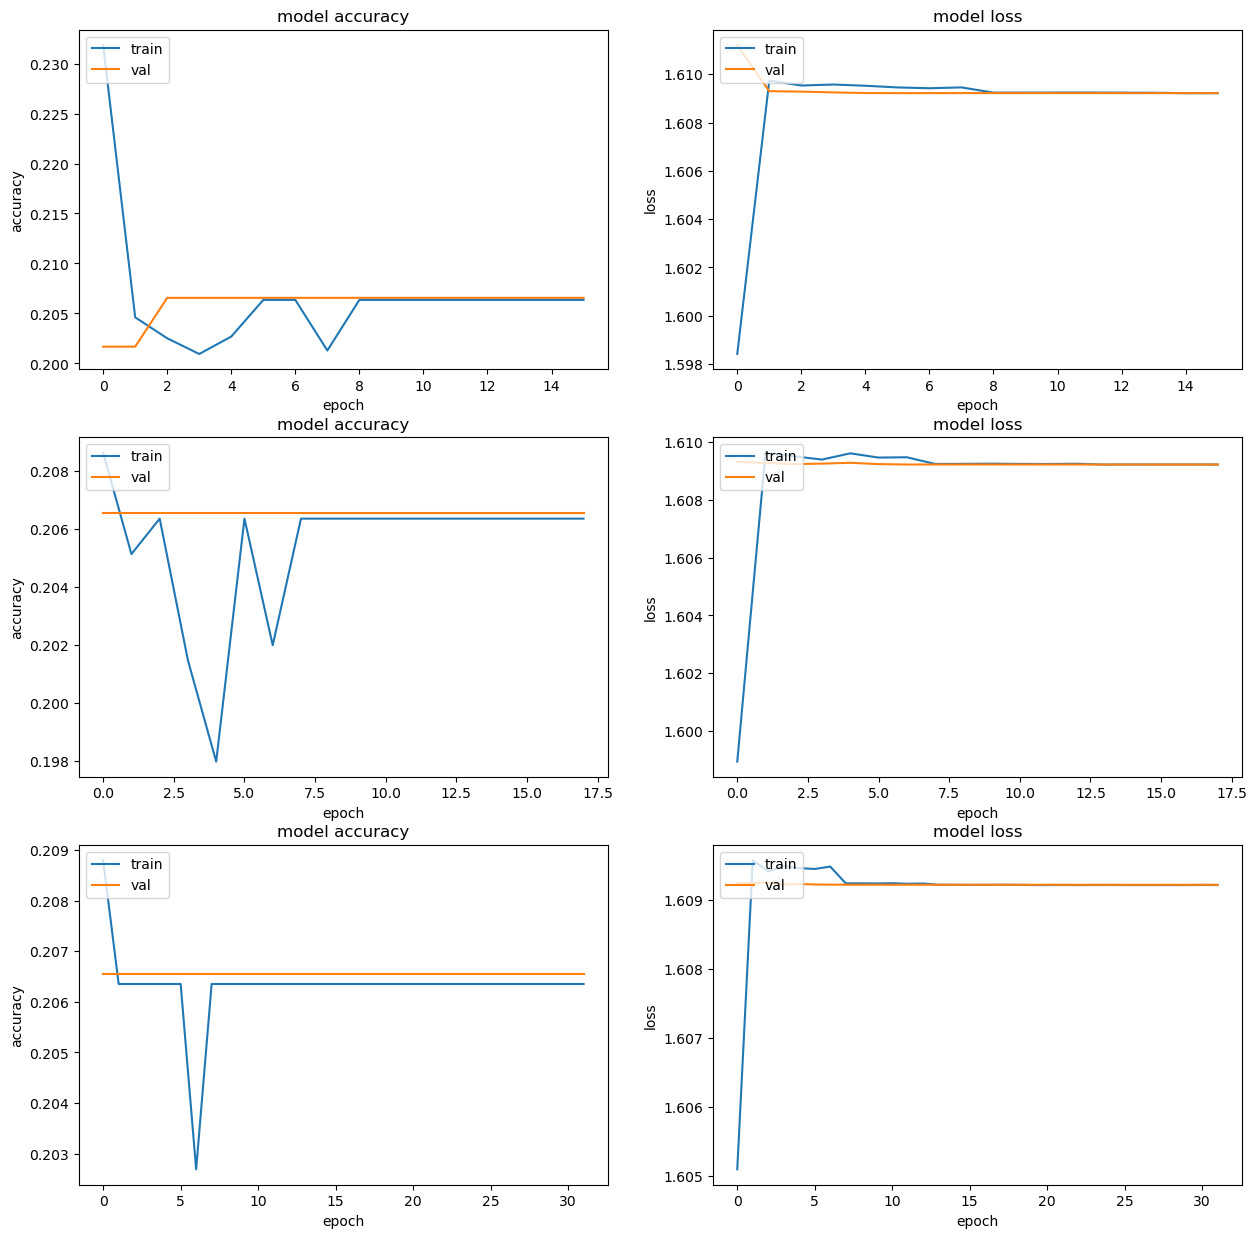

Epoch 1/50
179/179 [==============================] - 3s 15ms/step - loss: 1.5980 - accuracy: 0.2320 - val_loss: 1.5723 - val_accuracy: 0.2505
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5650 - accuracy: 0.2704 - val_loss: 1.5522 - val_accuracy: 0.2903
Epoch 3/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5335 - accuracy: 0.3141 - val_loss: 1.4846 - val_accuracy: 0.3531
Epoch 4/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4640 - accuracy: 0.3776 - val_loss: 1.4122 - val_accuracy: 0.4229
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4168 - accuracy: 0.4221 - val_loss: 1.3492 - val_accuracy: 0.4983
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.3375 - accuracy: 0.4815 - val_loss: 1.3080 - val_accuracy: 0.5143
Epoch 7/50
179/179 [==============================] - 2s 13ms/step - loss: 1.2836 - accuracy: 0.5249 - val_loss: 1.2714 - val_accuracy: 0.5422

179/179 [==============================] - 2s 13ms/step - loss: 0.5573 - accuracy: 0.8287 - val_loss: 1.0482 - val_accuracy: 0.6092
Epoch 27/50
179/179 [==============================] - 2s 12ms/step - loss: 0.5194 - accuracy: 0.8468 - val_loss: 1.0169 - val_accuracy: 0.6085
Epoch 28/50
179/179 [==============================] - 2s 12ms/step - loss: 0.5182 - accuracy: 0.8374 - val_loss: 1.0453 - val_accuracy: 0.6071
Epoch 29/50
179/179 [==============================] - 2s 12ms/step - loss: 0.5210 - accuracy: 0.8364 - val_loss: 1.0732 - val_accuracy: 0.6022
Epoch 30/50
179/179 [==============================] - 2s 12ms/step - loss: 0.5193 - accuracy: 0.8342 - val_loss: 1.0827 - val_accuracy: 0.5987

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 31/50
179/179 [==============================] - 2s 13ms/step - loss: 0.4426 - accuracy: 0.8675 - val_loss: 1.0583 - val_accuracy: 0.6141
Epoch 32/50
179/179 [==============================] - 2s 13ms/ste

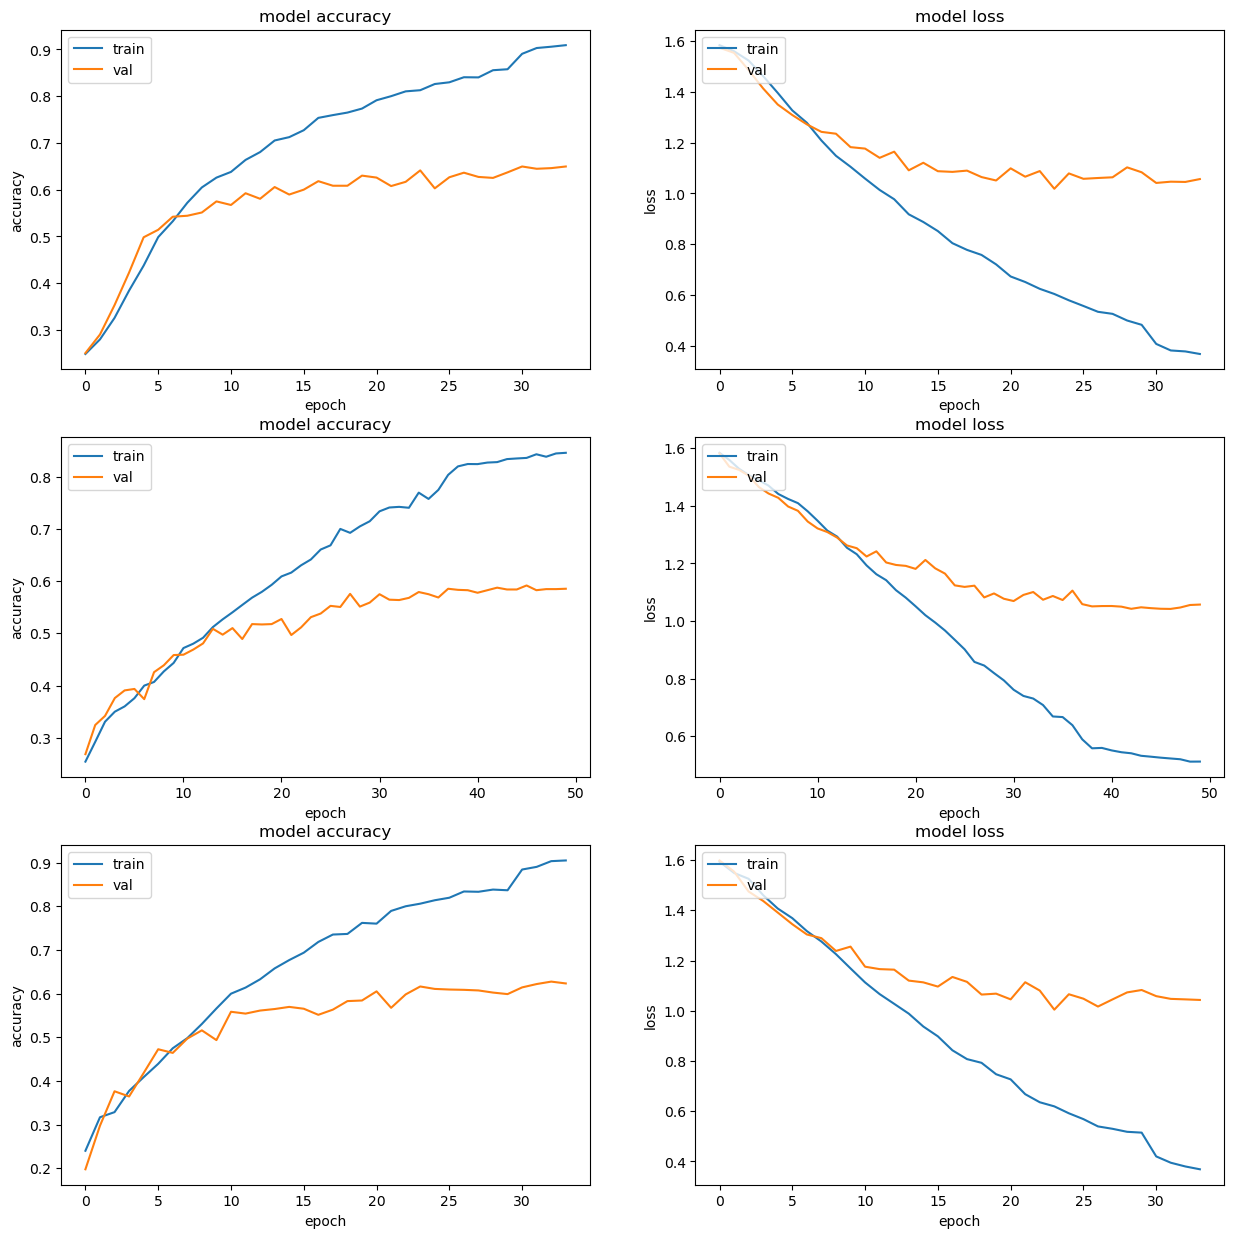

In [21]:
ravdess1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [22]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.5847 - accuracy: 0.2587 - val_loss: 1.5443 - val_accuracy: 0.2924
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5506 - accuracy: 0.2858 - val_loss: 1.5236 - val_accuracy: 0.3126
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5289 - accuracy: 0.3051 - val_loss: 1.5107 - val_accuracy: 0.3175
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5181 - accuracy: 0.3137 - val_loss: 1.5197 - val_accuracy: 0.2987
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.5183 - accuracy: 0.3025 - val_loss: 1.4876 - val_accuracy: 0.3182
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4807 - accuracy: 0.3333 - val_loss: 1.4724 - val_accuracy: 0.3385
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4757 - accuracy: 0.3444 - val_loss: 1.4679 - val_accuracy: 0.3412

Epoch 7/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5207 - accuracy: 0.3014 - val_loss: 1.5014 - val_accuracy: 0.3489
Epoch 8/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4949 - accuracy: 0.3281 - val_loss: 1.4791 - val_accuracy: 0.3378
Epoch 9/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4689 - accuracy: 0.3425 - val_loss: 1.4587 - val_accuracy: 0.3545
Epoch 10/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4566 - accuracy: 0.3600 - val_loss: 1.4181 - val_accuracy: 0.4201
Epoch 11/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4294 - accuracy: 0.3914 - val_loss: 1.3974 - val_accuracy: 0.4264
Epoch 12/50
179/179 [==============================] - 2s 12ms/step - loss: 1.4056 - accuracy: 0.4122 - val_loss: 1.4226 - val_accuracy: 0.4061
Epoch 13/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4179 - accuracy: 0.3966 - val_loss: 1.3777 - val_accuracy: 0.

Epoch 13/50
179/179 [==============================] - 2s 13ms/step - loss: 1.2819 - accuracy: 0.5011 - val_loss: 1.2674 - val_accuracy: 0.4934
Epoch 14/50
179/179 [==============================] - 2s 13ms/step - loss: 1.2343 - accuracy: 0.5223 - val_loss: 1.2810 - val_accuracy: 0.4808
Epoch 15/50
179/179 [==============================] - 2s 13ms/step - loss: 1.2247 - accuracy: 0.5121 - val_loss: 1.2619 - val_accuracy: 0.4878
Epoch 16/50
179/179 [==============================] - 2s 13ms/step - loss: 1.2349 - accuracy: 0.5230 - val_loss: 1.2470 - val_accuracy: 0.4976
Epoch 17/50
179/179 [==============================] - 2s 13ms/step - loss: 1.1976 - accuracy: 0.5363 - val_loss: 1.2156 - val_accuracy: 0.5094
Epoch 18/50
179/179 [==============================] - 2s 12ms/step - loss: 1.1675 - accuracy: 0.5528 - val_loss: 1.2203 - val_accuracy: 0.5066
Epoch 19/50
179/179 [==============================] - 2s 13ms/step - loss: 1.1549 - accuracy: 0.5562 - val_loss: 1.2035 - val_accuracy:

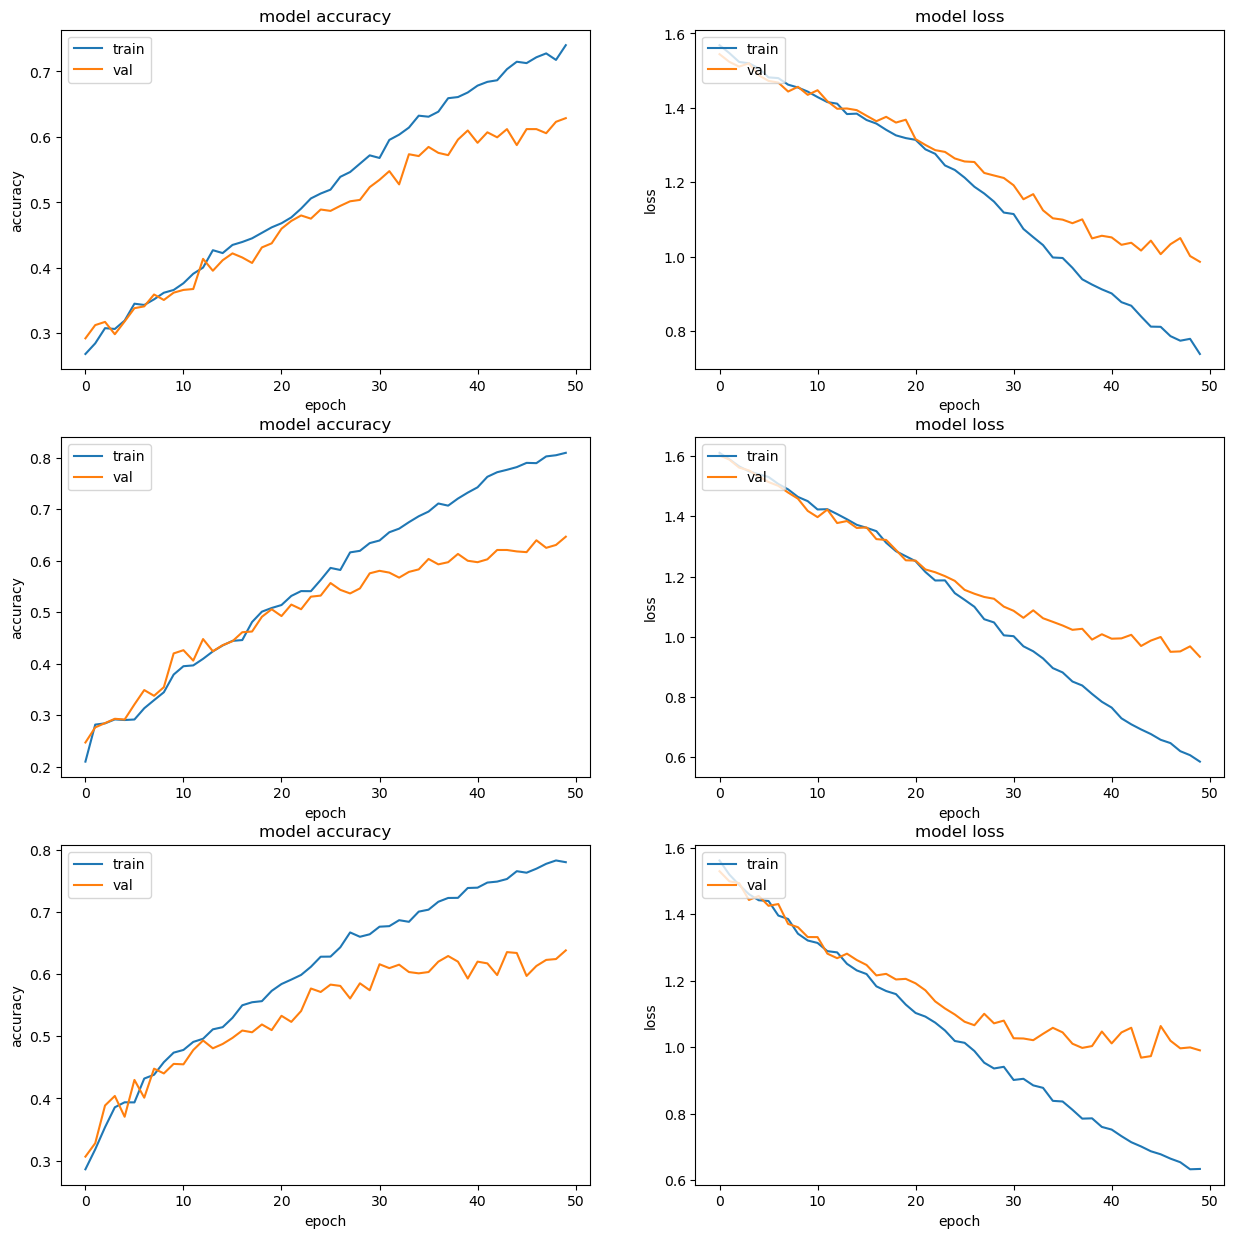

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.5893 - accuracy: 0.2471 - val_loss: 1.6539 - val_accuracy: 0.1940
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6104 - accuracy: 0.1921 - val_loss: 1.6126 - val_accuracy: 0.1940
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6097 - accuracy: 0.2061 - val_loss: 1.6094 - val_accuracy: 0.2066
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6100 - accuracy: 0.2060 - val_loss: 1.6093 - val_accuracy: 0.2066
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6099 - accuracy: 0.2024 - val_loss: 1.6093 - val_accuracy: 0.2066
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6097 - accuracy: 0.2025 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6098 - accuracy: 0.1979 - val_loss: 1.6092 - val_accuracy: 0.2066

Epoch 18/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6099 - accuracy: 0.1980 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 19/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6095 - accuracy: 0.2048 - val_loss: 1.6092 - val_accuracy: 0.2066

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6091 - accuracy: 0.2040 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 21/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6089 - accuracy: 0.2103 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 22/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6085 - accuracy: 0.2200 - val_loss: 1.6092 - val_accuracy: 0.2066
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Done
Evaluate on test data
56/56 [==============================] - 0s 5ms/step - loss: 1.6092 - accuracy: 0.2066


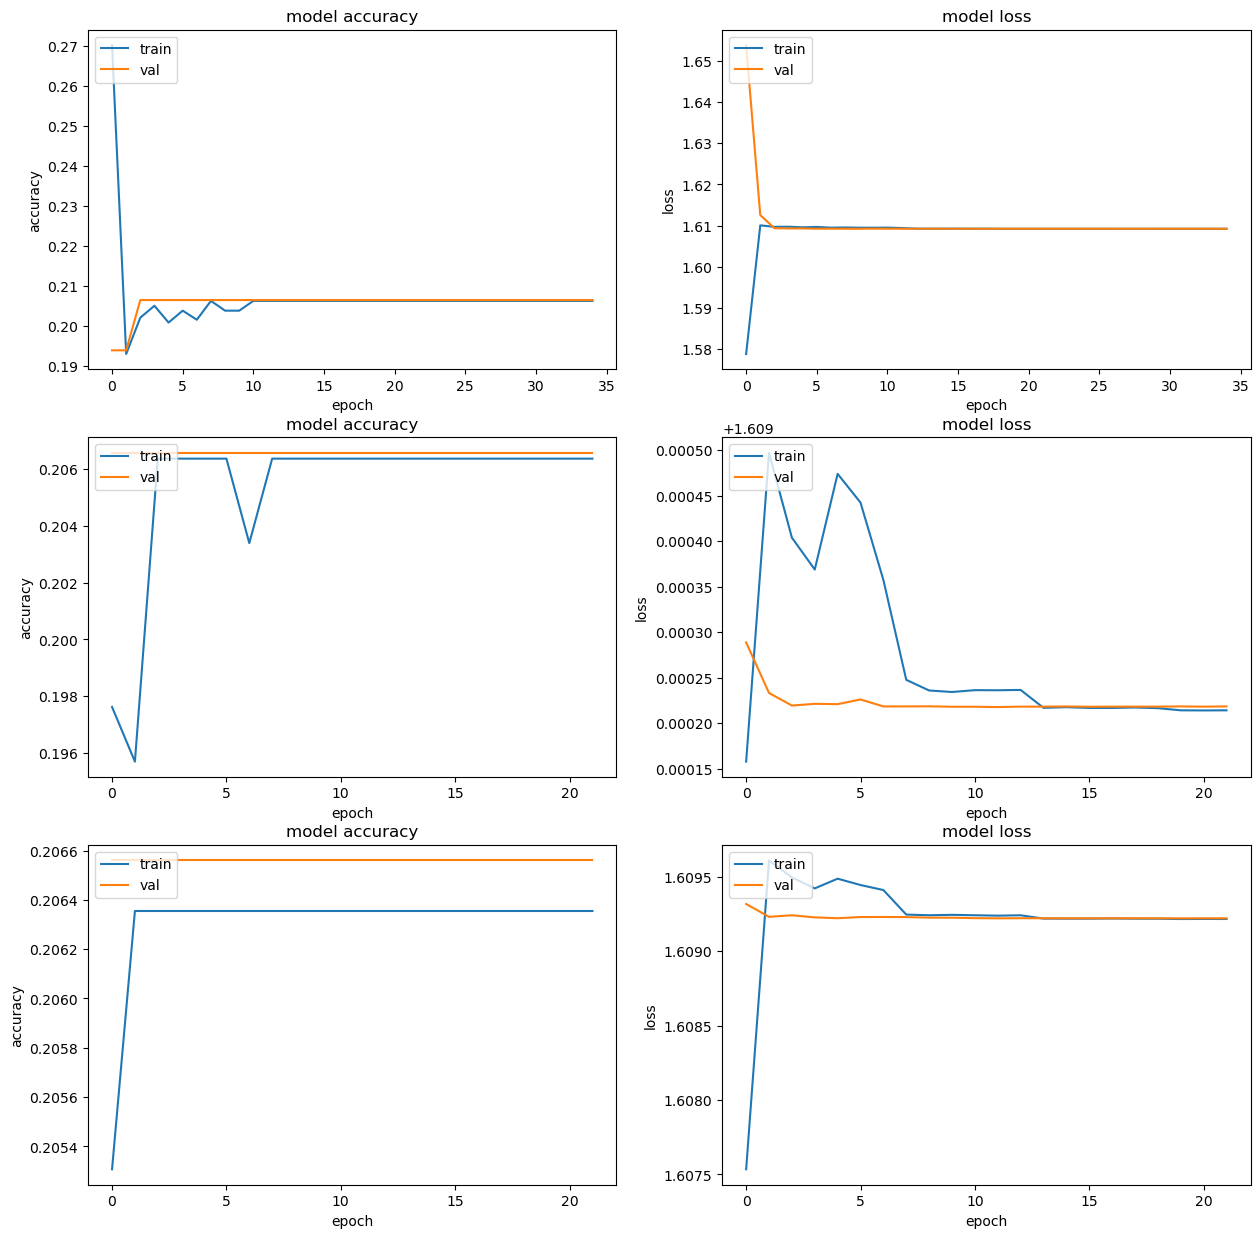

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.6003 - accuracy: 0.2262 - val_loss: 1.6098 - val_accuracy: 0.2017
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.2041 - val_loss: 1.6093 - val_accuracy: 0.2017
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6100 - accuracy: 0.1855 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6095 - accuracy: 0.2030 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6091 - accuracy: 0.2043 - val_loss: 1.6093 - val_accuracy: 0.2066
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6092 - accuracy: 0.2077 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6095 - accuracy: 0.2051 - val_loss: 1.6092 - val_accuracy: 0.2066

179/179 [==============================] - 2s 12ms/step - loss: 1.6091 - accuracy: 0.2135 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6096 - accuracy: 0.1947 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6093 - accuracy: 0.2056 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6091 - accuracy: 0.2102 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 8/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6092 - accuracy: 0.1999 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 9/50
179/179 [==============================] - 2s 12ms/step - loss: 1.6096 - accuracy: 0.2014 - val_loss: 1.6092 - val_accuracy: 0.2066
Epoch 10/5

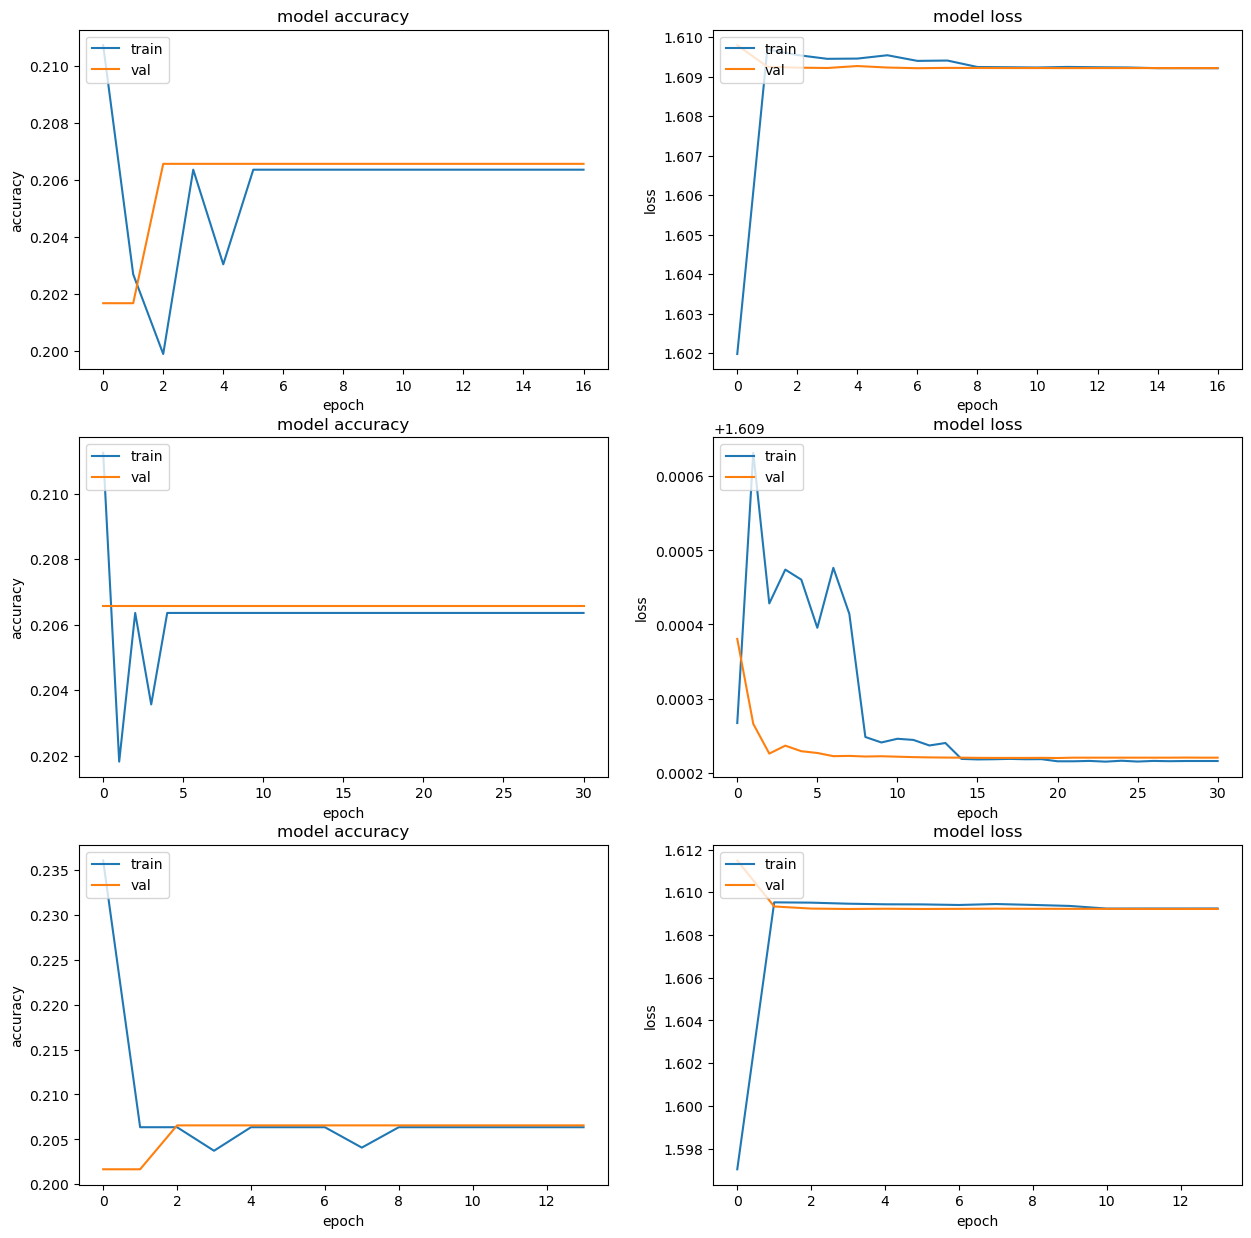

Epoch 1/50
179/179 [==============================] - 4s 15ms/step - loss: 1.5790 - accuracy: 0.2570 - val_loss: 1.5357 - val_accuracy: 0.3280
Epoch 2/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5426 - accuracy: 0.3278 - val_loss: 1.5236 - val_accuracy: 0.3482
Epoch 3/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5283 - accuracy: 0.3202 - val_loss: 1.4958 - val_accuracy: 0.3552
Epoch 4/50
179/179 [==============================] - 2s 13ms/step - loss: 1.5067 - accuracy: 0.3408 - val_loss: 1.4806 - val_accuracy: 0.3775
Epoch 5/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4997 - accuracy: 0.3473 - val_loss: 1.4642 - val_accuracy: 0.3894
Epoch 6/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4694 - accuracy: 0.3792 - val_loss: 1.4608 - val_accuracy: 0.3761
Epoch 7/50
179/179 [==============================] - 2s 13ms/step - loss: 1.4565 - accuracy: 0.3791 - val_loss: 1.4302 - val_accuracy: 0.4020

Epoch 18/50
179/179 [==============================] - 2s 13ms/step - loss: 1.0407 - accuracy: 0.6414 - val_loss: 1.2574 - val_accuracy: 0.5122
Epoch 19/50
179/179 [==============================] - 2s 13ms/step - loss: 1.0395 - accuracy: 0.6333 - val_loss: 1.2446 - val_accuracy: 0.5241
Epoch 20/50
179/179 [==============================] - 2s 13ms/step - loss: 1.0032 - accuracy: 0.6577 - val_loss: 1.2300 - val_accuracy: 0.5352
Epoch 21/50
179/179 [==============================] - 2s 13ms/step - loss: 0.9626 - accuracy: 0.6663 - val_loss: 1.2340 - val_accuracy: 0.5262
Epoch 22/50
179/179 [==============================] - 2s 13ms/step - loss: 0.9328 - accuracy: 0.6791 - val_loss: 1.2669 - val_accuracy: 0.5150
Epoch 23/50
179/179 [==============================] - 2s 13ms/step - loss: 0.8969 - accuracy: 0.7088 - val_loss: 1.1770 - val_accuracy: 0.5499
Epoch 24/50
179/179 [==============================] - 2s 13ms/step - loss: 0.8849 - accuracy: 0.7106 - val_loss: 1.1788 - val_accuracy:

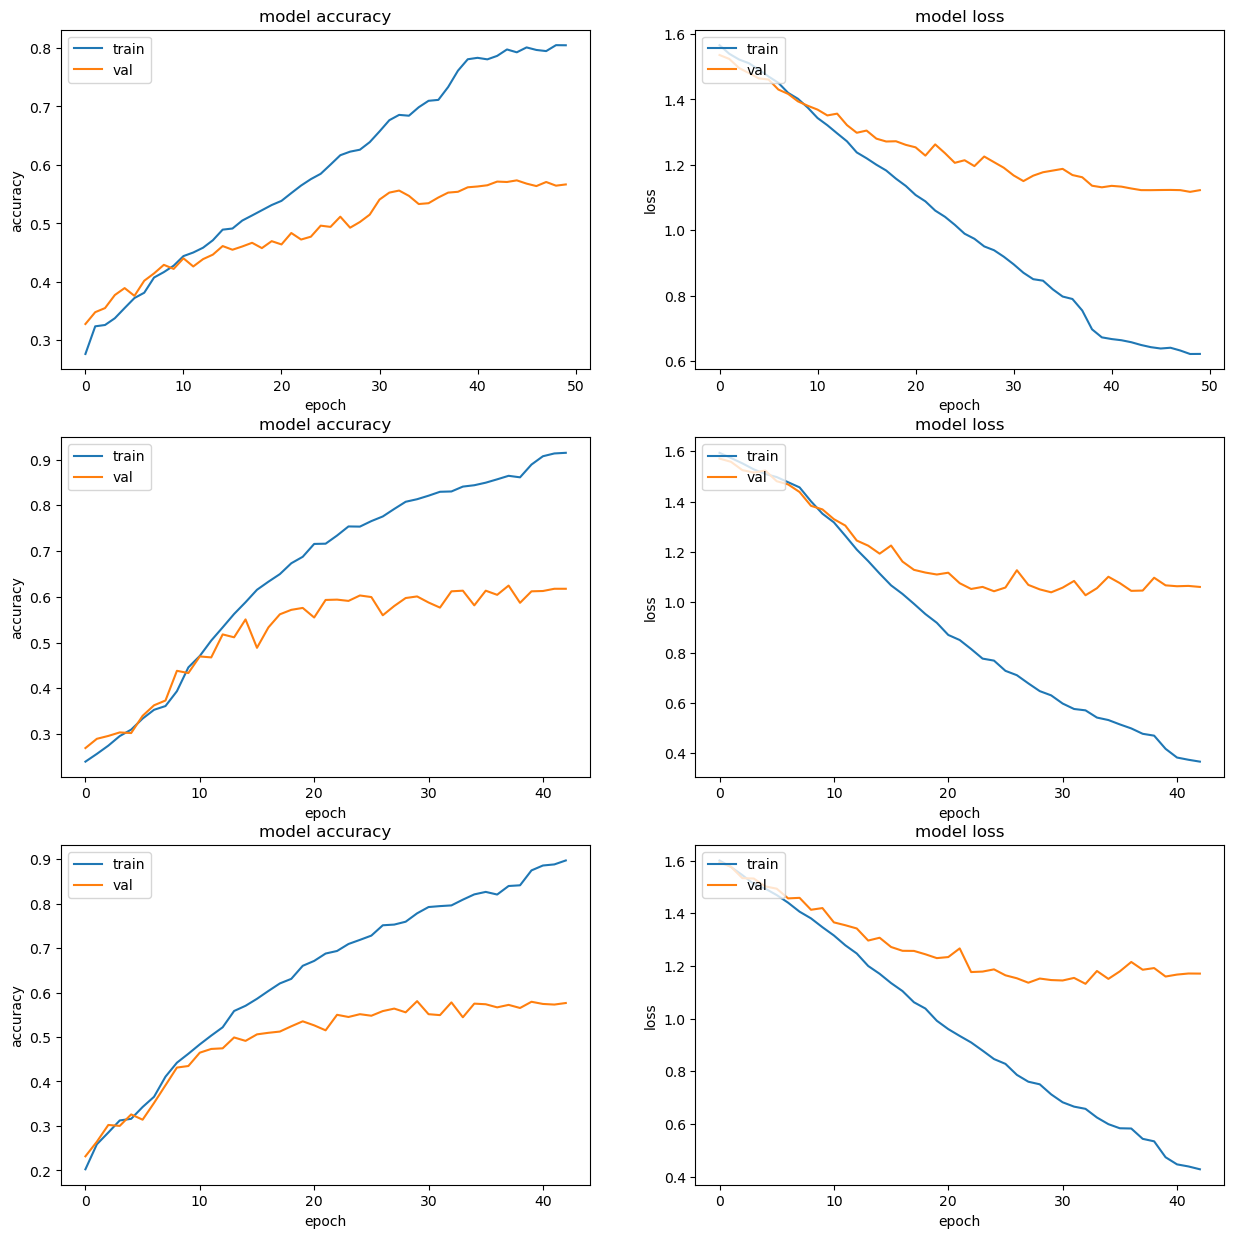

In [23]:
ravdess2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# Results comparison

In [24]:
def get_mean_acc(p):
    acc = [[test[1][1] for test in exp ] for exp in p]
    return np.asarray([np.mean(exp) for exp in acc])

In [32]:
def get_std_acc(p):
    acc = [[test[1][1] for test in exp ] for exp in p]
    return np.asarray([np.std(exp) for exp in acc])

In [33]:
get_std_acc(emodb1)

array([0.04477766, 0.15566647, 0.00439879, 0.06509615])

In [34]:
get_std_acc(emodb2)

array([0.02439408, 0.00996414, 0.01639116, 0.02384172])

In [25]:
get_mean_acc(emodb1)

array([0.68339306, 0.46395858, 0.78693746, 0.62724014])

In [26]:
get_mean_acc(emodb2)

array([0.71166865, 0.7136599 , 0.68180009, 0.68140183])

In [27]:
np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2)))

array([0.68339306, 0.46395858, 0.78693746, 0.62724014, 0.71166865,
       0.7136599 , 0.68180009, 0.68140183])

In [28]:
index = ['original', 'norm1', 'norm2', 'norm3', 'original std', 'norm1 std', 'norm2 std', 'norm3 std']

In [29]:
union = pd.concat([pd.DataFrame(np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2))), columns=['emodb'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(emovo1), get_mean_acc(emovo2))), columns=['emovo'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(ravdess1), get_mean_acc(ravdess2))), columns=['ravdess'], index=index)
                  ], axis=1)

In [30]:
union['mean'] = union.mean(axis=1)

In [31]:
union

emodb     emovo   ravdess      mean
original      0.683393  0.353259  0.451145  0.495932
norm1         0.463959  0.291118  0.206588  0.320555
norm2         0.786937  0.364066  0.206588  0.452531
norm3         0.627240  0.481256  0.603201  0.570566
original std  0.711669  0.599122  0.623302  0.644697
norm1 std     0.713660  0.353597  0.206588  0.424615
norm2 std     0.681800  0.241810  0.206588  0.376733
norm3 std     0.681402  0.424519  0.583287  0.563069

In [35]:
union = pd.concat([pd.DataFrame(np.concatenate((get_std_acc(emodb1), get_std_acc(emodb2))), columns=['emodb'], index=index),
                   pd.DataFrame(np.concatenate((get_std_acc(emovo1), get_std_acc(emovo2))), columns=['emovo'], index=index),
                   pd.DataFrame(np.concatenate((get_std_acc(ravdess1), get_std_acc(ravdess2))), columns=['ravdess'], index=index)
                  ], axis=1)

In [36]:
union['mean'] = union.mean(axis=1)

In [37]:
union

emodb     emovo   ravdess      mean
original      0.044778  0.128510  0.099683  0.090990
norm1         0.155666  0.100776  0.000000  0.085481
norm2         0.004399  0.203941  0.000000  0.069447
norm3         0.065096  0.022851  0.025564  0.037837
original std  0.024394  0.069751  0.010054  0.034733
norm1 std     0.009964  0.189135  0.000000  0.066366
norm2 std     0.016391  0.031045  0.000000  0.015812
norm3 std     0.023842  0.151647  0.009610  0.061699